# Initial

In [3]:
%reload_ext autoreload
%autoreload 2
import time
from loguru import logger
import datetime
import datetime
from loguru import logger
import os,sys
import time
import pandas as pd
from pathlib import Path
project_path = Path.cwd().parent
log_path = Path(project_path, "log")
log_time = time.strftime("%Y_%m")
log_path="./logs"
if ~os.path.exists(log_path):
    os.makedirs(log_path, exist_ok=True)
logger.remove()
logger.add(f'logs/nca2_{log_time}.log', format="{time:YYYY-MM-DD HH:mm:ss} | "
                               "{file} | "
                               "{process.name} | "
                               "{thread.name} | "
                               "{module}.{function}:{line} - {level} -{message}",level="INFO", enqueue=True,encoding="utf-8", rotation="12:00")
logger.add(sys.stderr, format='{time:YYYY-MM-DD HH:mm:ss} | ' 
                                "{file} | "# 
                               "{process.name} | "  # 进程名
                               "{thread.name} | "  # 进程名
                               '{module}.{function}:{line} - {level} -{message}',level="INFO", enqueue=True
)
DEBUG=True
def get_cost_time(function):
    """
    计算程序运行时间
    :param function:
    :return:
    """
    def func(*args, **kwargs):
        if DEBUG:
            start_time = datetime.datetime.now()
            result = function(*args, **kwargs)
            end_time = datetime.datetime.now()
            seconds = (end_time - start_time).seconds
            start = start_time.strftime('%Y-%m-%d %H:%M')
            minutes = seconds // 60
            second = seconds % 60
            timeStr = str(minutes) + '分钟' + str(second) + "秒"
            logger.info('---function: %s，cost time:%s seconds---' %( function.__name__,timeStr))
        else:
            result = function(*args, **kwargs)
        return result
    return func
class StopWatch:

    def __init__(self):
        self.start = datetime.datetime.now()

    def reset(self):
        self.start =  datetime.datetime.now()

    def stop(self, msg='Time it took: '):
        time_range =  datetime.datetime.now() - self.start
        seconds = time_range.seconds
        start_time = self.start.strftime('%Y-%m-%d %H:%M')
        logger.info('---%s start from %s, total cost time:%s seconds---' %(msg,start_time,seconds))
        self.reset()
        return seconds



# Drug data sample

In [4]:
Drug_dict = {'Acetaminophen':{'individual':{'race': 'European','gender': 'MALE','species': 'Human', 'age': 30, 'height': 176, 'weight': 73},\
                              'molecule':{'logp': 0.91,'fu': 0.52, 'mw': 151.165, 'ct': ['acid','neutral','neutral'], 'pka': [9.46,0,0],\
                                          #'bp':1.04,
                                          'perm':0.06012},\
                              'calc_method':{'kmethod': 5, 'pmethod': 1, 'emethod':'RT-PCR'},\
                                'enzyme':{},'transporter':{},'protein':{},\
                                'administration':{'iv_infusion':{},'dose':1000,'time':0.0833333,'unit':'mg'},'type':'sm','CL':21900},
             'Alprazolam':{'individual':{'race': 'European','gender': 'MALE','species': 'Human', 'age': 30, 'height': 176, 'weight': 73},\
                         'molecule':{'logp': 3.02, 'fu': 0.29, 'mw': 308.77, 'ct': ['base','neutral','neutral'], 'pka': [5.01,0,0],\
                                     #'bp':0.78,
                                     'perm':1.926},\
                              'calc_method':{'kmethod': 5, 'pmethod': 1, 'emethod':'RT-PCR'},\
                                'enzyme':{},'transporter':{},'protein':{},\
                                'administration':{'iv':{},'dose':0.25,'unit':'mg'},'type':'sm','CL':3241.2}}

Simulation_IV_Time = {'Acetaminophen':6,
             'Alprazolam':24,
             'Amitriptyline':12,
            }
Observation_IV_path = {'Acetaminophen':"./new_test/dataset/acetaminophen/acetaminophen_iv_obs.csv",
             'Alprazolam':"./new_test/dataset/alp_iv_0.25mg.csv"
             }
#import os
name = []
thalf_pred = []
thalf_obs = []
aucinf_prd = []
aucinf_obs =[]
cl_prd = []
cl_obs = []
vd_prd = []
vd_obs = []
vss_prd = []
vss_obs = []


# Replace  cl caco2 fup with predict value

In [5]:
import pandas as pd
pre = pd.read_csv("../dataset/df_pred_result_2023_06_20_18_57.csv")
for key,value in Drug_dict.items():
    for i,x in enumerate(pre['Name']):
        if x == key:
            Drug_dict[key]['molecule']['perm'] = pre['caco2_pred'][i]*3600/1000000
            Drug_dict[key]['molecule']['fu'] = pre['fu_pred'][i]
            Drug_dict[key]['CL'] = pre['cl_pred'][i]*1000*Drug_dict[key]['individual']['weight']
print(Drug_dict)


{'Acetaminophen': {'individual': {'race': 'European', 'gender': 'MALE', 'species': 'Human', 'age': 30, 'height': 176, 'weight': 73}, 'molecule': {'logp': 0.91, 'fu': 0.3395816915723152, 'mw': 151.165, 'ct': ['acid', 'neutral', 'neutral'], 'pka': [9.46, 0, 0], 'perm': 0.0690309493035392}, 'calc_method': {'kmethod': 5, 'pmethod': 1, 'emethod': 'RT-PCR'}, 'enzyme': {}, 'transporter': {}, 'protein': {}, 'administration': {'iv_infusion': {}, 'dose': 1000, 'time': 0.0833333, 'unit': 'mg'}, 'type': 'sm', 'CL': 29102.74550733642}, 'Alprazolam': {'individual': {'race': 'European', 'gender': 'MALE', 'species': 'Human', 'age': 30, 'height': 176, 'weight': 73}, 'molecule': {'logp': 3.02, 'fu': 0.1715664592465537, 'mw': 308.77, 'ct': ['base', 'neutral', 'neutral'], 'pka': [5.01, 0, 0], 'perm': 0.1859848735956841}, 'calc_method': {'kmethod': 5, 'pmethod': 1, 'emethod': 'RT-PCR'}, 'enzyme': {}, 'transporter': {}, 'protein': {}, 'administration': {'iv': {}, 'dose': 0.25, 'unit': 'mg'}, 'type': 'sm', '

# Predict

2024-01-05 05:26:02 | 347445450.py | ForkPoolWorker-102 | MainThread | 347445450.run_simulation:31 - INFO -process :1 Alprazolam
2024-01-05 05:26:02 | 347445450.py | ForkPoolWorker-101 | MainThread | 347445450.run_simulation:31 - INFO -process :0 Acetaminophen
2024-01-05 05:26:02 | 347445450.py | ForkPoolWorker-104 | MainThread | 347445450.run_simulation:31 - INFO -process :3 Atenolol
2024-01-05 05:26:02 | 347445450.py | ForkPoolWorker-103 | MainThread | 347445450.run_simulation:31 - INFO -process :2 Amitriptyline
2024-01-05 05:26:02 | 347445450.py | ForkPoolWorker-105 | MainThread | 347445450.run_simulation:31 - INFO -process :4 Betaxolol
2024-01-05 05:26:02 | 347445450.py | ForkPoolWorker-107 | MainThread | 347445450.run_simulation:31 - INFO -process :6 Caffeine
2024-01-05 05:26:02 | 347445450.py | ForkPoolWorker-106 | MainThread | 347445450.run_simulation:31 - INFO -process :5 Bosentan
2024-01-05 05:26:02 | 347445450.py | ForkPoolWorker-108 | MainThread | 347445450.run_simulation:31

1.3492035770995434
86.30121347345624


/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:339: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:308: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


25.471718242554793
0.7828103438381658
1.6147810094855906
0.7266088751170285
0.6810439894034942


/data/project/pbpk/ML_PBPK_test/params_calc_function.py:844: RuntimeWarning: divide by zero encountered in scalar divide
  Ka_AP = max(0,Kpu_bc - (1+Z)/(1+Y)*f_iw_bc_RR - (10**user_input['molecule']['logp']*f_nl_bc_RR + (0.3*10**user_input['molecule']['logp']+0.7)*f_np_bc_RR)/(1+Y)) * (1+Y)/AP_bc_RR/Z


0.655058518394943


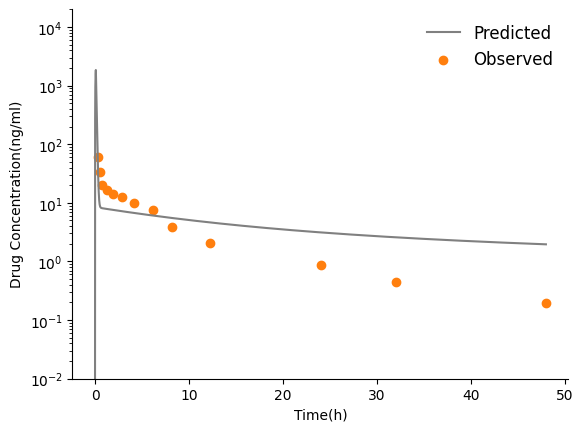

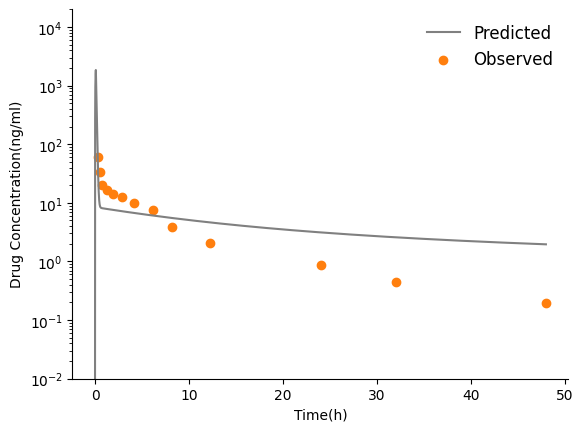

36.776591610134446
1.093164647368214


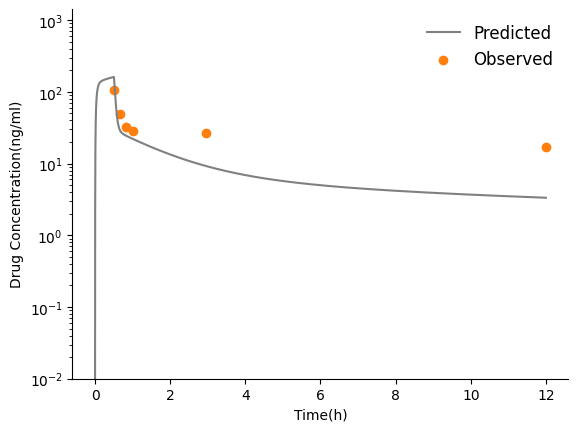

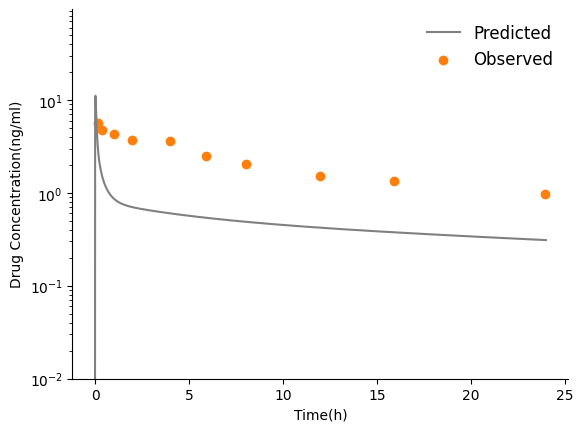

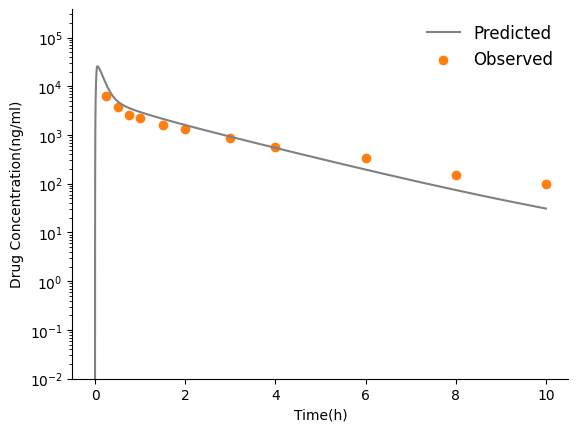

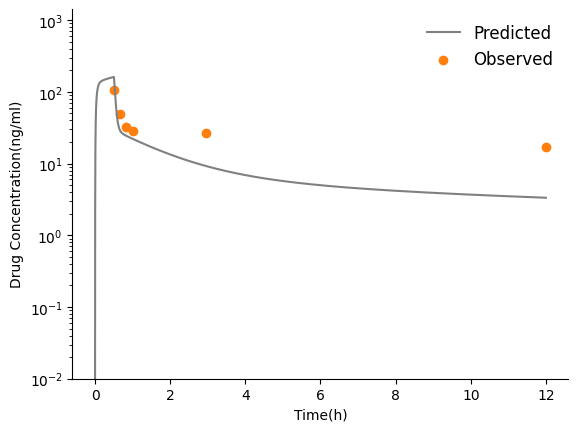

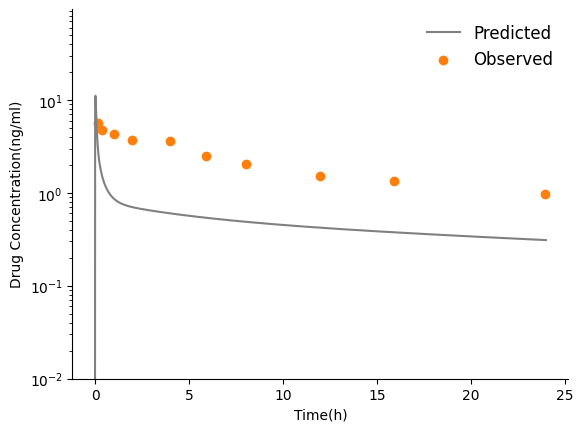

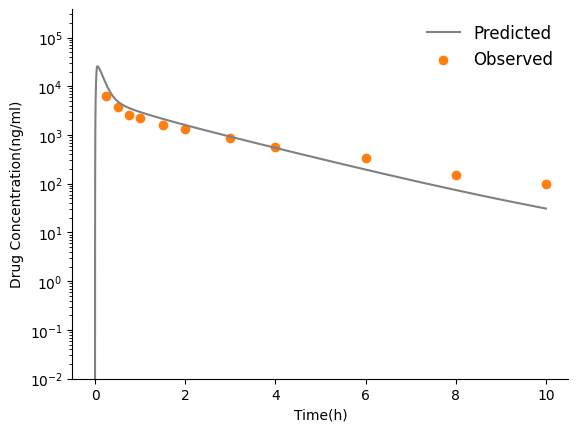

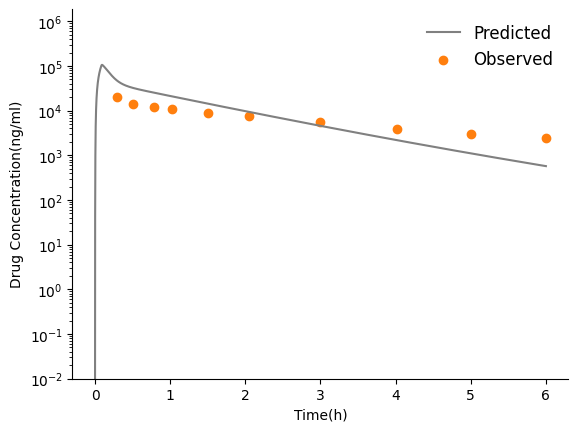

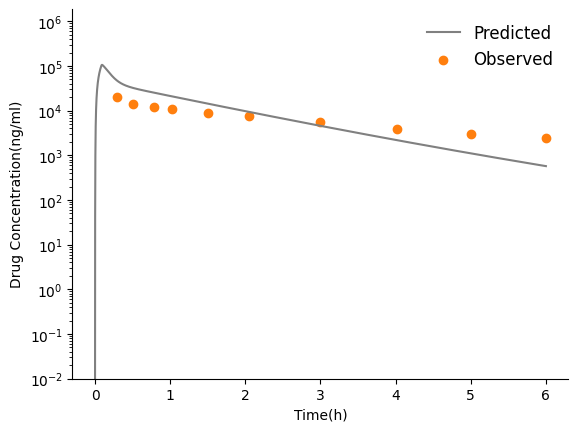

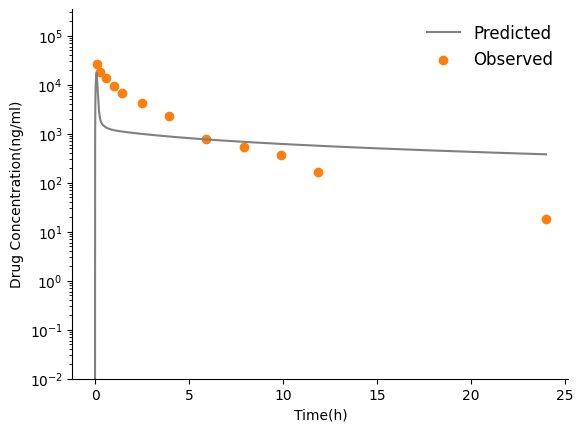

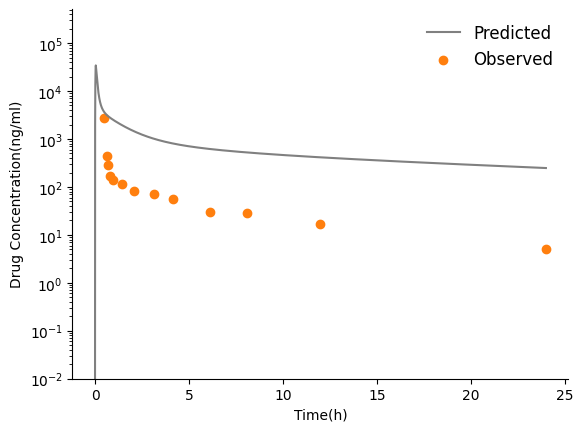

/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:339: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:308: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


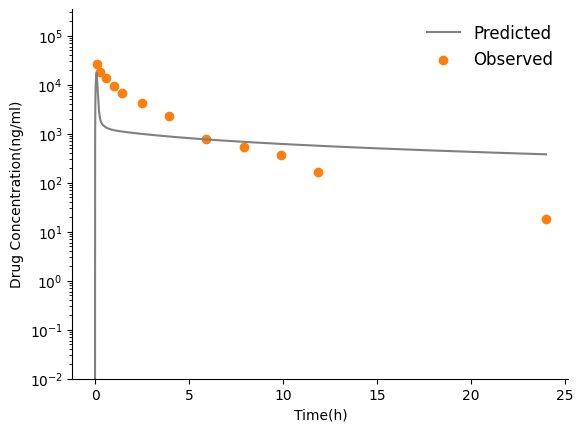

/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:339: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:308: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/config/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


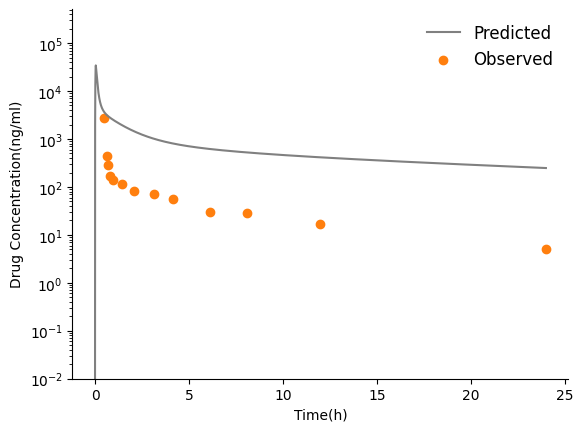

Alprazolam 31.009679761331952 26.317197160540623 0.13013002537296886 5.821693469040639 5.275368704553242
Alprazolam 17.988136584471395 72.91124321903463 0.04697022548303654 1.21894289566285 1.0731651846277972


2024-01-05 05:26:22 | 347445450.py | ForkPoolWorker-102 | MainThread | 347445450.run_simulation:31 - INFO -process :10 Desipramine
2024-01-05 05:26:22 | fullbody_model_sm.py | ForkPoolWorker-102 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 12.5, 'time': 0.5, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 12.5, 'unit': 'mg', 'infusion_time': 0.5, 'time_range': {'start': 0}}]}
2024-01-05 05:26:22 | fullbody_model_sm.py | ForkPoolWorker-102 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 12.5, 'unit': 'mg', 'infusion_time': 0.5, 'time_range': {'start': 0}}


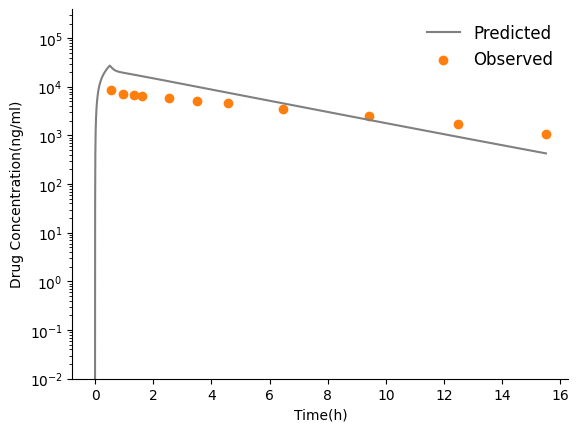

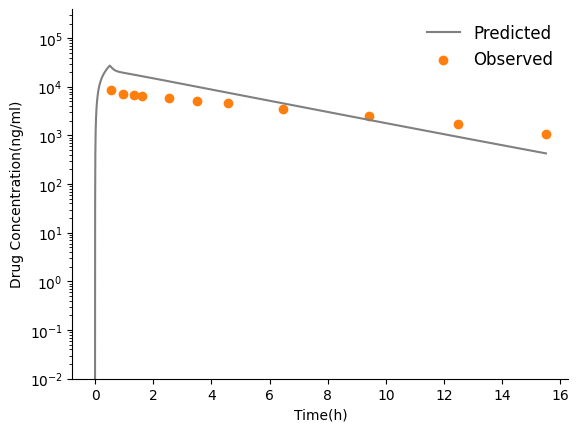

Chlorpromazine 48.60825610700984 516.9299039851618 0.6624994042412525 46.45902286738832 25.017608340925275
Chlorpromazine 10.545329402386132 145.1403272108544 2.3595492721132993 35.89746162639594 19.435978443263114


2024-01-05 05:26:23 | 347445450.py | ForkPoolWorker-108 | MainThread | 347445450.run_simulation:31 - INFO -process :11 Dexamethasone


Amitriptyline 14.98631348451714 230.29982472319892 0.892225829098062 19.290529268322395 10.866818139558367
Amitriptyline 15.008525202920755 677.9328635909587 0.3030970514784982 6.562877068000417 6.267122136327053


2024-01-05 05:26:24 | 347445450.py | ForkPoolWorker-103 | MainThread | 347445450.run_simulation:31 - INFO -process :12 Diazepam
2024-01-05 05:26:24 | fullbody_model_sm.py | ForkPoolWorker-103 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 0.1, 'time': 0.167, 'unit': 'mg/kg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 0.1, 'unit': 'mg/kg', 'infusion_time': 0.167, 'time_range': {'start': 0}}]}
2024-01-05 05:26:24 | fullbody_model_sm.py | ForkPoolWorker-103 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 0.1, 'unit': 'mg/kg', 'infusion_time': 0.167, 'time_range': {'start': 0}}


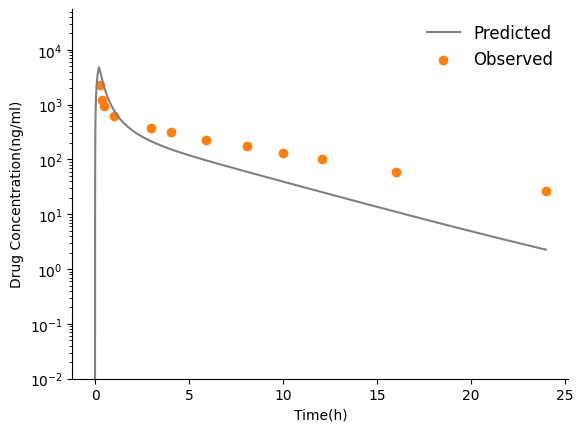

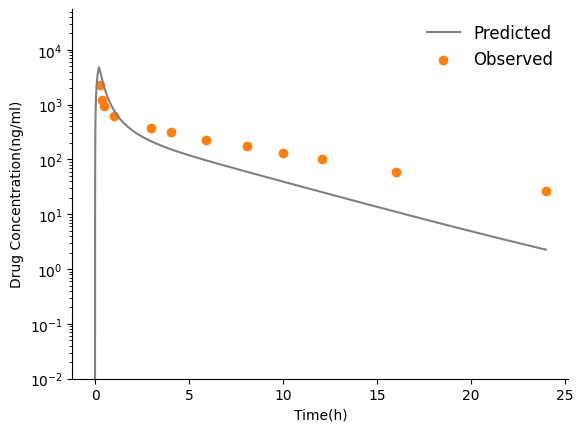

Cimetidine 1.692488987373953 13154.562062765857 0.2838304458081454 0.693041704971894 0.38732170068265237
Cimetidine 2.0815958596582624 8090.310447506757 0.46149838611401844 1.3859295063392831 1.2847038881971864


2024-01-05 05:26:25 | 347445450.py | ForkPoolWorker-109 | MainThread | 347445450.run_simulation:31 - INFO -process :13 Diclofenac
2024-01-05 05:26:25 | fullbody_model_sm.py | ForkPoolWorker-109 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 50, 'time': 0.033, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 50, 'unit': 'mg', 'infusion_time': 0.033, 'time_range': {'start': 0}}]}
2024-01-05 05:26:25 | fullbody_model_sm.py | ForkPoolWorker-109 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 50, 'unit': 'mg', 'infusion_time': 0.033, 'time_range': {'start': 0}}


Acetaminophen 1.0789461081537015 68620.35330943989 0.19962925686513222 0.31074094479364706 0.24086540358249706
Acetaminophen 2.3952074799448986 48090.678008603034 0.2848500105266914 0.9843145799493147 0.9736874935401834


2024-01-05 05:26:26 | 347445450.py | ForkPoolWorker-101 | MainThread | 347445450.run_simulation:31 - INFO -process :14 Diltiazem
2024-01-05 05:26:26 | fullbody_model_sm.py | ForkPoolWorker-101 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 15, 'time': 0.5, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 15, 'unit': 'mg', 'infusion_time': 0.5, 'time_range': {'start': 0}}]}
2024-01-05 05:26:26 | fullbody_model_sm.py | ForkPoolWorker-101 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 15, 'unit': 'mg', 'infusion_time': 0.5, 'time_range': {'start': 0}}


Bosentan 25.032914728010688 30723.5452523792 0.11055817623038613 3.992793270577669 3.4920389355788175
Bosentan 3.3068125530897916 34350.89975104807 0.09888355632754994 0.4717459646794664 0.2538391293045224


2024-01-05 05:26:27 | 347445450.py | ForkPoolWorker-106 | MainThread | 347445450.run_simulation:31 - INFO -process :15 Furosemide


Clozapine 18.065215647836677 25269.628714830367 0.16262957748500806 4.238549142780729 2.8007044819982685
Clozapine 6.422853056485772 947.2059260227849 4.338643718532896 40.20281961771875 27.321449881984147


2024-01-05 05:26:27 | 347445450.py | ForkPoolWorker-110 | MainThread | 347445450.run_simulation:31 - INFO -process :16 Ibuprofen
2024-01-05 05:26:27 | fullbody_model_sm.py | ForkPoolWorker-110 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 200, 'time': 0.05, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 200, 'unit': 'mg', 'infusion_time': 0.05, 'time_range': {'start': 0}}]}
2024-01-05 05:26:27 | fullbody_model_sm.py | ForkPoolWorker-110 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 200, 'unit': 'mg', 'infusion_time': 0.05, 'time_range': {'start': 0}}


6.9971904233260656


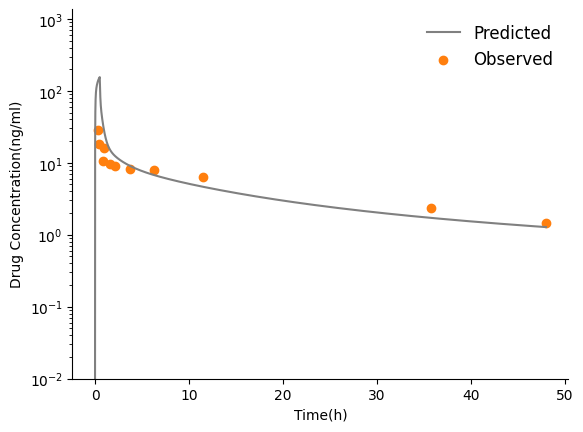

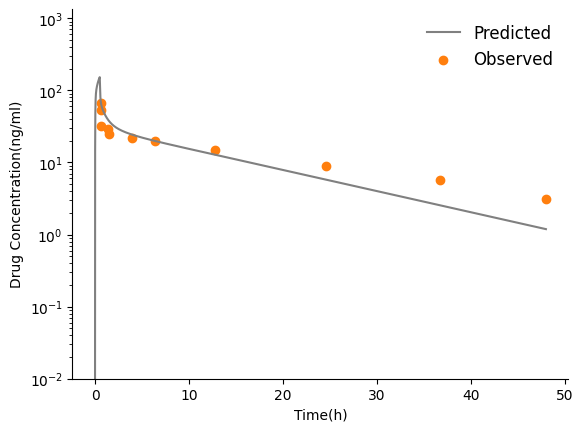

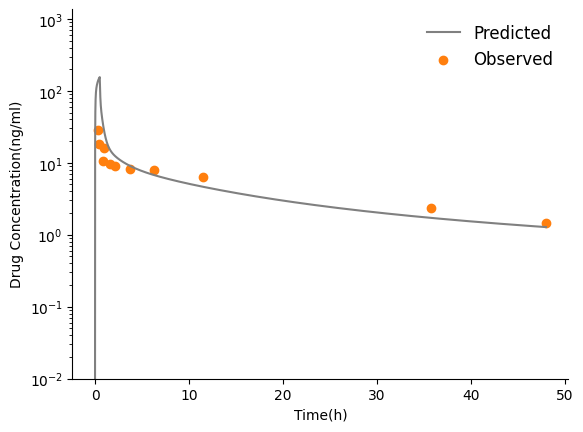

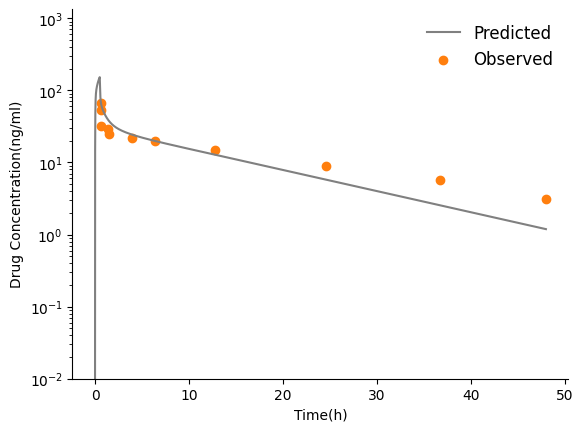

0.6788495853309533
0.7281905260173137
Desipramine

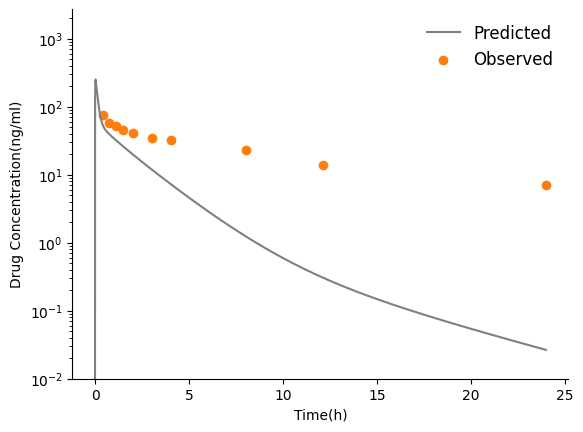

 32.790333975192894 315.035245238235 0.5435356179999464 25.71274174012132 14.547268925890636
Desipramine 17.17437956466023 260.39414520064764 0.6575911166527368 16.293393023137533 15.174123257252443


2024-01-05 05:26:37 | 347445450.py | ForkPoolWorker-102 | MainThread | 347445450.run_simulation:31 - INFO -process :17 Imipramine
2024-01-05 05:26:37 | fullbody_model_sm.py | ForkPoolWorker-102 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 12.5, 'time': 0.5, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 12.5, 'unit': 'mg', 'infusion_time': 0.5, 'time_range': {'start': 0}}]}
2024-01-05 05:26:37 | fullbody_model_sm.py | ForkPoolWorker-102 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 12.5, 'unit': 'mg', 'infusion_time': 0.5, 'time_range': {'start': 0}}


0.9003868914938267


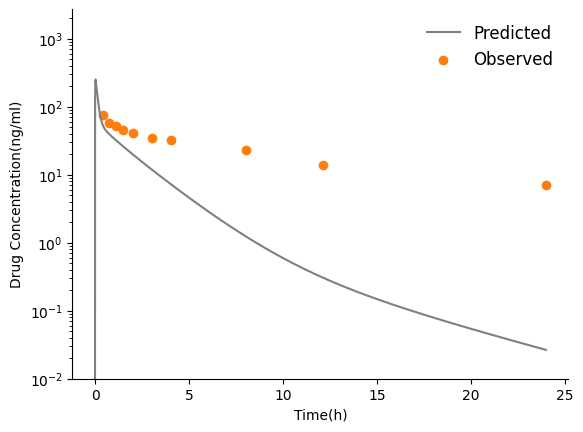

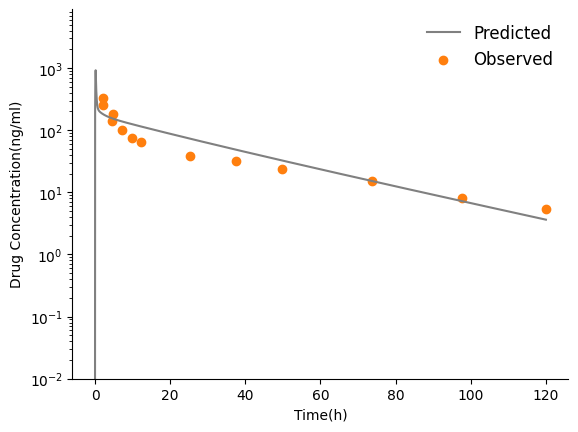

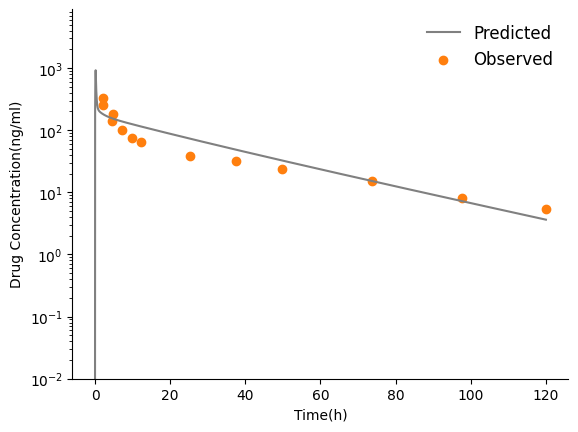

1.056219780364514
3.475219327170084
0.6166008922023917


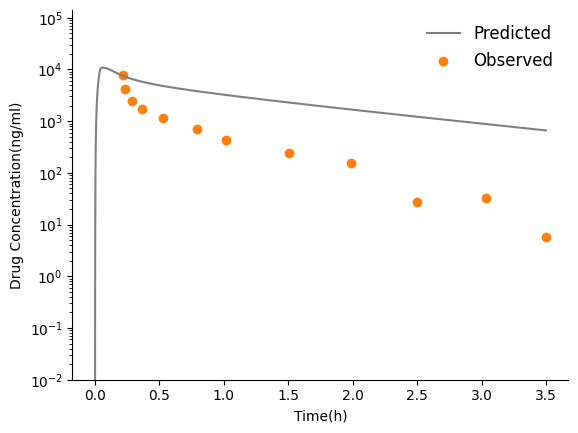

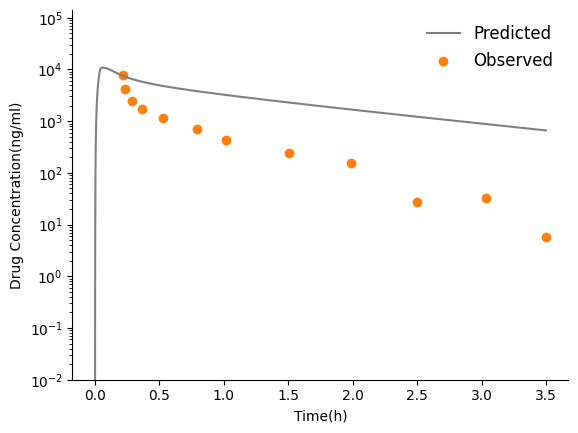

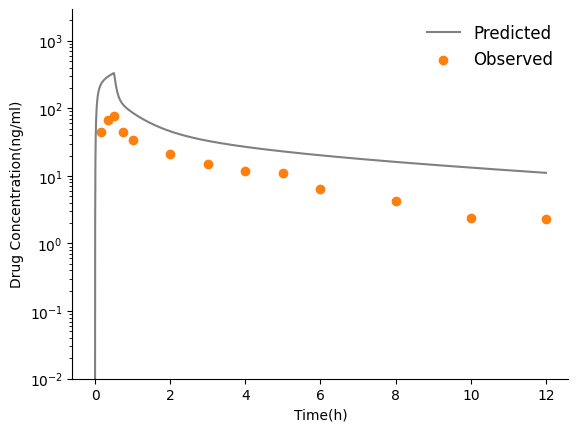

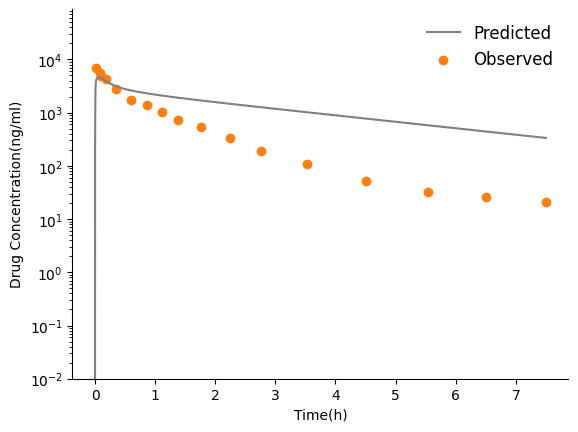

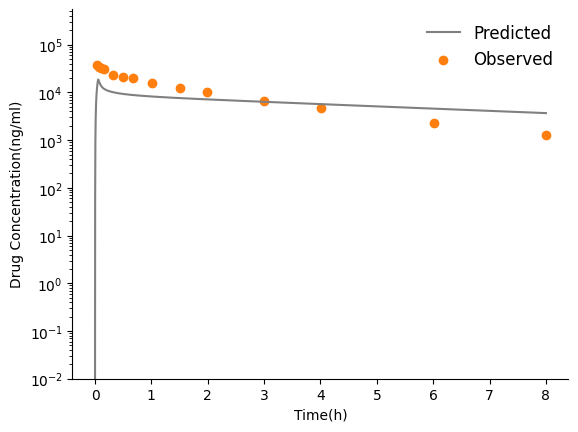

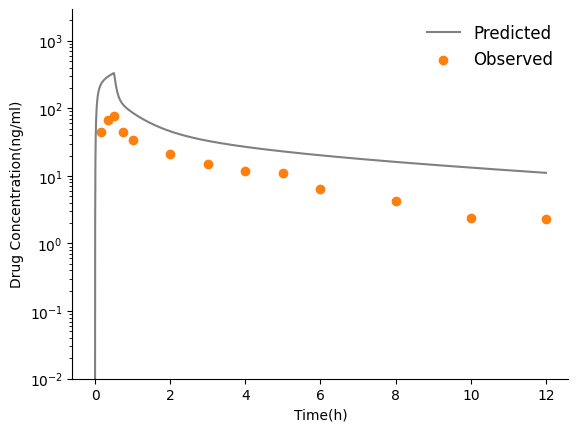

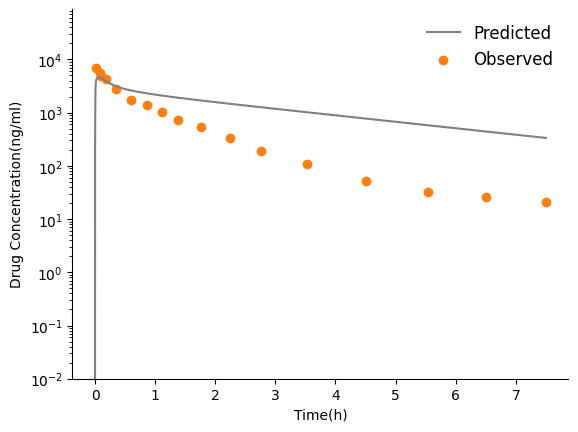

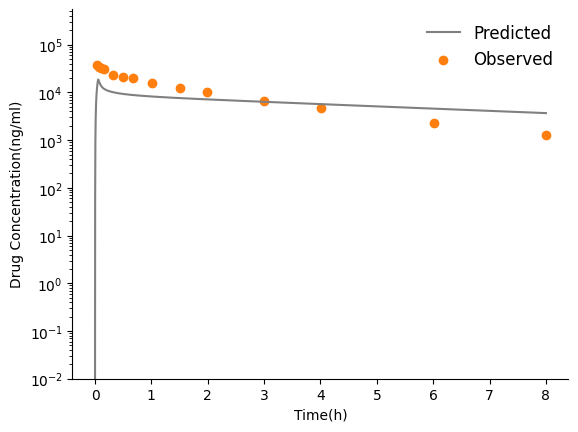

Caffeine 2.7067459270886682 92075.45547699895 0.054303288255240105 0.21205482534554054 0.21446732210064678
Caffeine 5.433136009894602 62050.58332392877 0.08057941975981124 0.6316103699646818 0.6398469109757535


2024-01-05 05:26:41 | 347445450.py | ForkPoolWorker-107 | MainThread | 347445450.run_simulation:31 - INFO -process :18 Ketoprofen
2024-01-05 05:26:41 | fullbody_model_sm.py | ForkPoolWorker-107 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 100, 'time': 1.5, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 100, 'unit': 'mg', 'infusion_time': 1.5, 'time_range': {'start': 0}}]}
2024-01-05 05:26:41 | fullbody_model_sm.py | ForkPoolWorker-107 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 100, 'unit': 'mg', 'infusion_time': 1.5, 'time_range': {'start': 0}}


Dexamethasone 3.9334906301528947 142.41953295619527 0.38474020670183384 2.183334276685947 0.6944187626773204
Dexamethasone 8.64044886085705 554.4628027043715 0.0988245203838508 1.2319002926414437 1.225062222274016


2024-01-05 05:26:42 | 347445450.py | ForkPoolWorker-108 | MainThread | 347445450.run_simulation:31 - INFO -process :19 Lidocaine
2024-01-05 05:26:42 | fullbody_model_sm.py | ForkPoolWorker-108 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 100, 'time': 0.0167, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 100, 'unit': 'mg', 'infusion_time': 0.0167, 'time_range': {'start': 0}}]}
2024-01-05 05:26:42 | fullbody_model_sm.py | ForkPoolWorker-108 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 100, 'unit': 'mg', 'infusion_time': 0.0167, 'time_range': {'start': 0}}


13.304763229173505
Diazepam 22.662424050289193 5465.915014796353 0.018295198467099795 0.5981609063325901 0.5387816527192169
Diazepam 31.71746294387797 4197.526860710417 0.023823552134000003 1.0901330239723046 0.879421282482233


2024-01-05 05:26:44 | 347445450.py | ForkPoolWorker-103 | MainThread | 347445450.run_simulation:31 - INFO -process :20 Methylprednisolone
2024-01-05 05:26:44 | fullbody_model_sm.py | ForkPoolWorker-103 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 0.3, 'time': 0.0083, 'unit': 'mg/kg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 0.3, 'unit': 'mg/kg', 'infusion_time': 0.0083, 'time_range': {'start': 0}}]}
2024-01-05 05:26:44 | fullbody_model_sm.py | ForkPoolWorker-103 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 0.3, 'unit': 'mg/kg', 'infusion_time': 0.0083, 'time_range': {'start': 0}}


Diclofenac 1.1464715155903724 10596.30873308327 0.06463868919851834 0.10691295881970543 0.09512081306575465
Diclofenac 0.414248255153311 1389.2841882494174 0.4930103665200209 0.29463970976327264 0.3659117491468349


2024-01-05 05:26:44 | 347445450.py | ForkPoolWorker-109 | MainThread | 347445450.run_simulation:31 - INFO -process :21 Metoprolol
2024-01-05 05:26:44 | fullbody_model_sm.py | ForkPoolWorker-109 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 15, 'time': 0.08, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 15, 'unit': 'mg', 'infusion_time': 0.08, 'time_range': {'start': 0}}]}
2024-01-05 05:26:44 | fullbody_model_sm.py | ForkPoolWorker-109 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 15, 'unit': 'mg', 'infusion_time': 0.08, 'time_range': {'start': 0}}


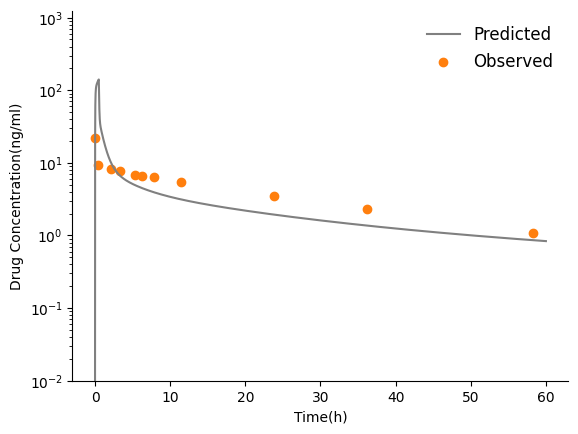

Furosemide 2.487899942519027 10434.6601949944 0.057214601550659765 0.20535927707899715 0.19300500767839399
Furosemide 3.1234092789630026 3892.879476306239 0.15336075237027688 0.6910630388702044 0.18769965596330546


2024-01-05 05:26:45 | 347445450.py | ForkPoolWorker-106 | MainThread | 347445450.run_simulation:31 - INFO -process :22 Midazolam


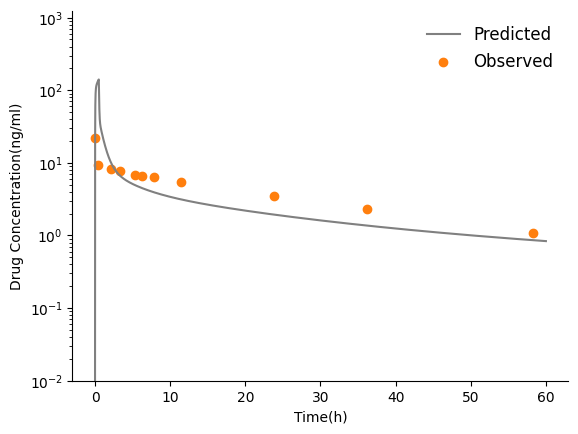

Diltiazem 7.950633243703172 580.7583248942262 0.33326838170081374 3.8227013669523178 2.502322003287672
Diltiazem 2.9319626730375425 156.97883440596445 1.2329584929662358 5.215325662669979 4.641592802381882


2024-01-05 05:26:46 | 347445450.py | ForkPoolWorker-101 | MainThread | 347445450.run_simulation:31 - INFO -process :23 Montelukast


Ibuprofen 6.460566391401513 82989.32321514387 0.03437872411224797 0.32043126742495015 0.313427904159861
Ibuprofen 2.066552443425299 63759.40437429945 0.04474739177810825 0.13341009587784283 0.11624070250194654


2024-01-05 05:26:46 | 347445450.py | ForkPoolWorker-110 | MainThread | 347445450.run_simulation:31 - INFO -process :24 Nadolol
2024-01-05 05:26:46 | fullbody_model_sm.py | ForkPoolWorker-110 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 4, 'time': 0.0167, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 4, 'unit': 'mg', 'infusion_time': 0.0167, 'time_range': {'start': 0}}]}
2024-01-05 05:26:46 | fullbody_model_sm.py | ForkPoolWorker-110 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 4, 'unit': 'mg', 'infusion_time': 0.0167, 'time_range': {'start': 0}}


0.6259040380666908


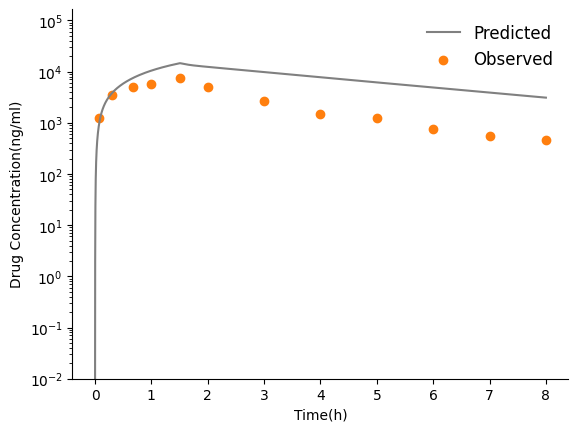

1.723131856082216


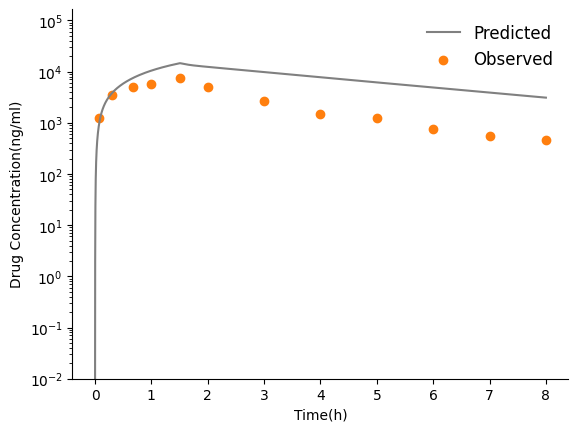

Imipramine 40.21681658019508 262.52851166025005 0.5907428783809227 34.2752573367027 18.80360961294422
Atenolol 3.7167691087282857 3745.377454546656 0.18015910034366445 0.9660427072251531 0.42444129630217153
Imipramine 20.30876203830881 242.92229718691124 0.6384216287725436 18.705338927263824 17.72753268706072


2024-01-05 05:26:52 | 347445450.py | ForkPoolWorker-102 | MainThread | 347445450.run_simulation:31 - INFO -process :25 Naloxone


Atenolol 5.7712328006194955 4730.65152219039 0.14263655428716504 1.187610342733319 0.9693677004104855


2024-01-05 05:26:52 | 347445450.py | ForkPoolWorker-104 | MainThread | 347445450.run_simulation:31 - INFO -process :26 Naproxen


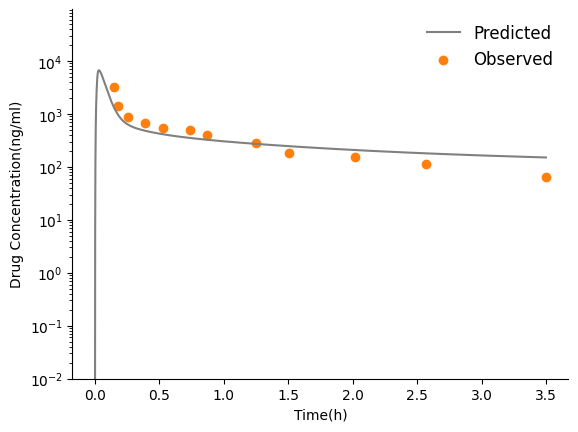

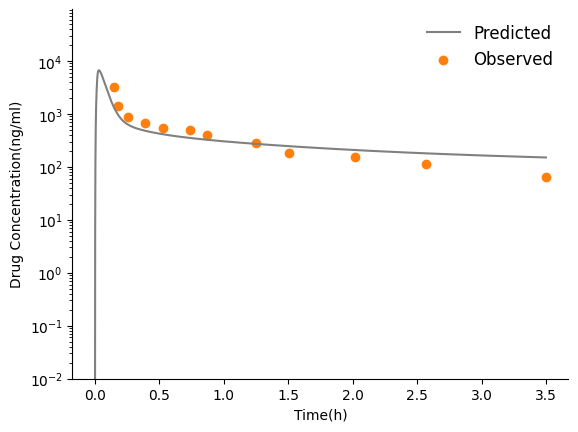

Ketoprofen 3.060082292822449 72140.95483547146 0.01898870089566756 0.08383066252623793 0.0962266096408478
Ketoprofen 1.9809185712041784 21159.547018984184 0.06473971358978524 0.1850171284558146 0.18983594599960762


2024-01-05 05:26:55 | 347445450.py | ForkPoolWorker-107 | MainThread | 347445450.run_simulation:31 - INFO -process :27 Nifedipine
2024-01-05 05:26:55 | fullbody_model_sm.py | ForkPoolWorker-107 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 0.015, 'time': 0.033, 'unit': 'mg/kg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 0.015, 'unit': 'mg/kg', 'infusion_time': 0.033, 'time_range': {'start': 0}}]}
2024-01-05 05:26:55 | fullbody_model_sm.py | ForkPoolWorker-107 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 0.015, 'unit': 'mg/kg', 'infusion_time': 0.033, 'time_range': {'start': 0}}


0.6571015370907886
0.927889681161159


/data/project/pbpk/ML_PBPK_test/params_calc_function.py:844: RuntimeWarning: divide by zero encountered in scalar divide
  Ka_AP = max(0,Kpu_bc - (1+Z)/(1+Y)*f_iw_bc_RR - (10**user_input['molecule']['logp']*f_nl_bc_RR + (0.3*10**user_input['molecule']['logp']+0.7)*f_np_bc_RR)/(1+Y)) * (1+Y)/AP_bc_RR/Z


Lidocaine 4.322665522589685 2350.674943660526 0.5827530588152897 3.6342159734236663 2.5835014070402296
Lidocaine 1.1711388273310481 1045.677119475121 1.3100248520176427 2.2134129835557896 1.9238281552458214


2024-01-05 05:26:58 | 347445450.py | ForkPoolWorker-108 | MainThread | 347445450.run_simulation:31 - INFO -process :28 Omeprazole
2024-01-05 05:26:58 | fullbody_model_sm.py | ForkPoolWorker-108 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 10, 'time': 0.083, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 10, 'unit': 'mg', 'infusion_time': 0.083, 'time_range': {'start': 0}}]}
2024-01-05 05:26:58 | fullbody_model_sm.py | ForkPoolWorker-108 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 10, 'unit': 'mg', 'infusion_time': 0.083, 'time_range': {'start': 0}}


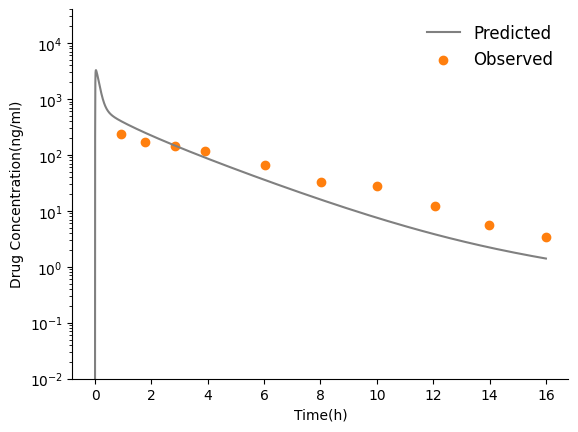

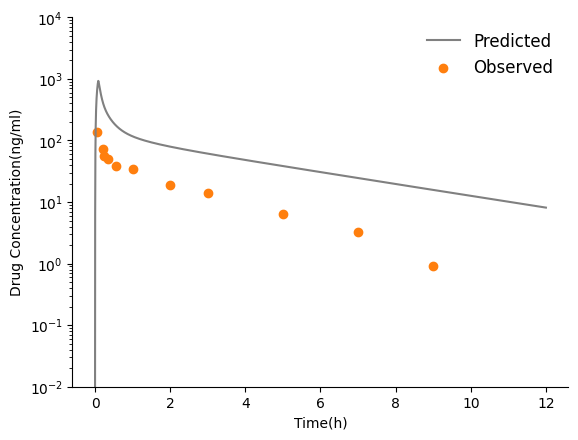

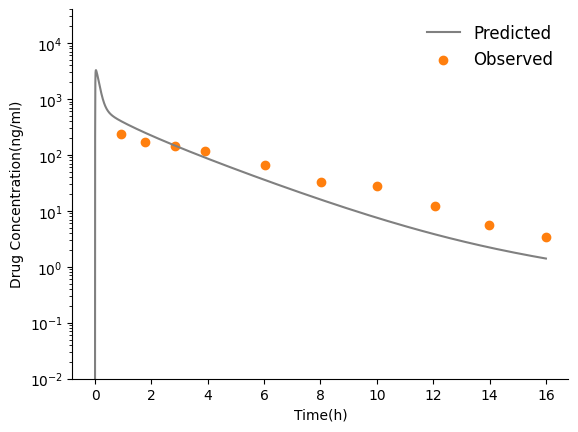

0.7647652492378934
2.898251093404415


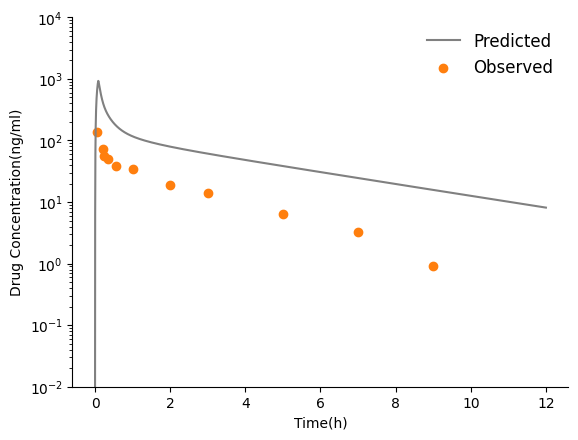

5023.231246805689


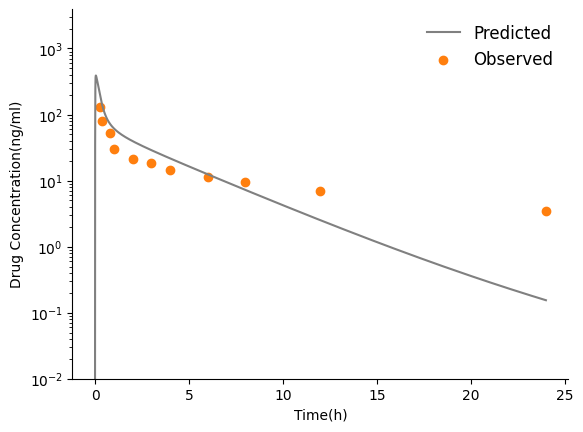

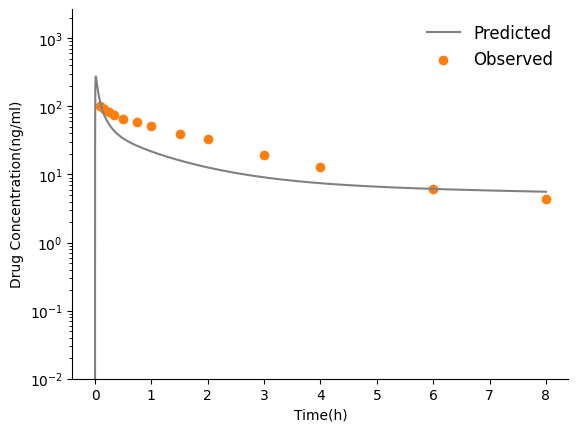

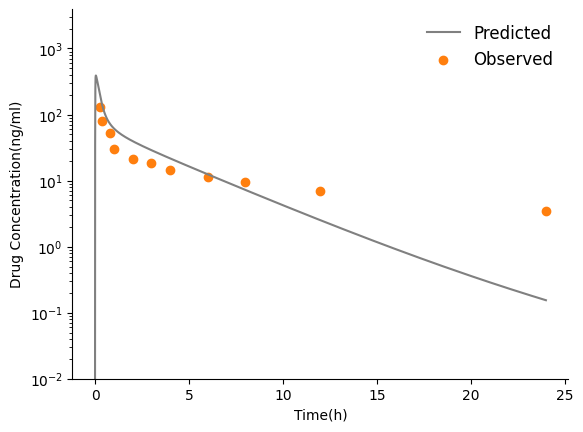

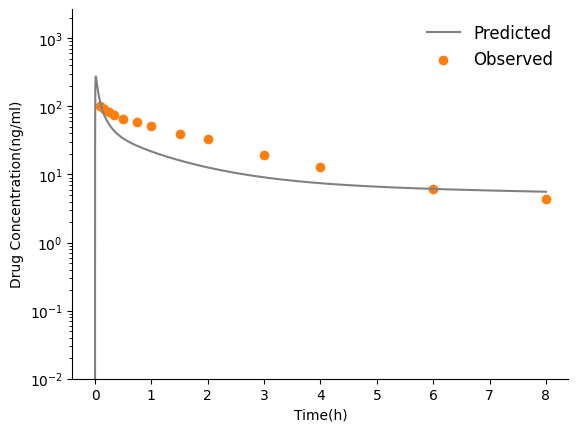

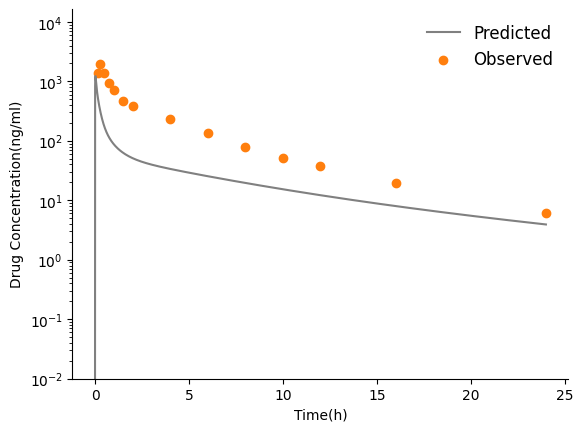

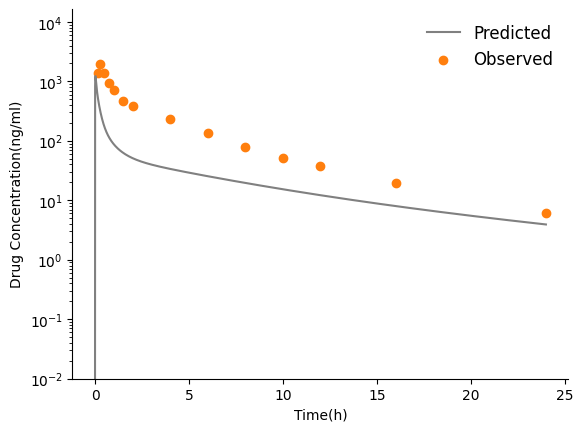

0.5980589983701038
0.816794214836619


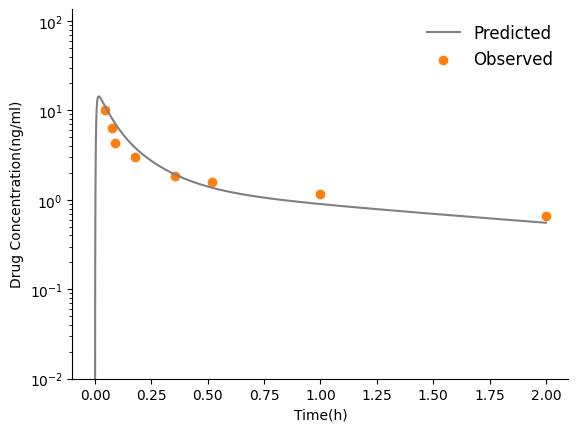

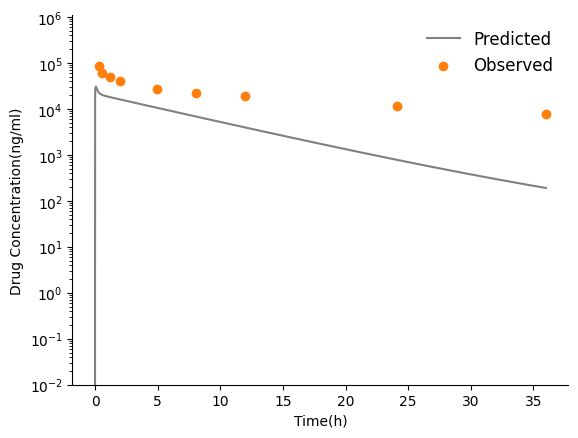

Methylprednisolone 3.310595707349277 1729.2822073749562 0.17348238403227362 0.8285830945947188 0.30151266377097663
Methylprednisolone 2.4190282610886213 1017.179137246345 0.29493330035468934 1.0292936460013933 1.2408965131572736


2024-01-05 05:27:04 | 347445450.py | ForkPoolWorker-103 | MainThread | 347445450.run_simulation:31 - INFO -process :29 Ondansetron
2024-01-05 05:27:04 | fullbody_model_sm.py | ForkPoolWorker-103 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 0.15, 'time': 0.25, 'unit': 'mg/kg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 0.15, 'unit': 'mg/kg', 'infusion_time': 0.25, 'time_range': {'start': 0}}]}
2024-01-05 05:27:04 | fullbody_model_sm.py | ForkPoolWorker-103 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 0.15, 'unit': 'mg/kg', 'infusion_time': 0.25, 'time_range': {'start': 0}}


0.5844635230206422


/data/project/pbpk/ML_PBPK_test/params_calc_function.py:844: RuntimeWarning: divide by zero encountered in scalar divide
  Ka_AP = max(0,Kpu_bc - (1+Z)/(1+Y)*f_iw_bc_RR - (10**user_input['molecule']['logp']*f_nl_bc_RR + (0.3*10**user_input['molecule']['logp']+0.7)*f_np_bc_RR)/(1+Y)) * (1+Y)/AP_bc_RR/Z


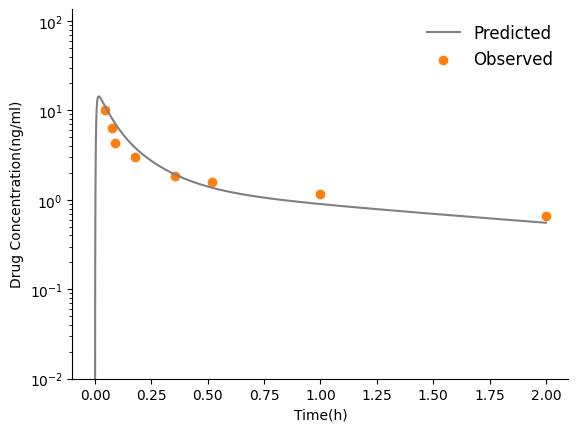

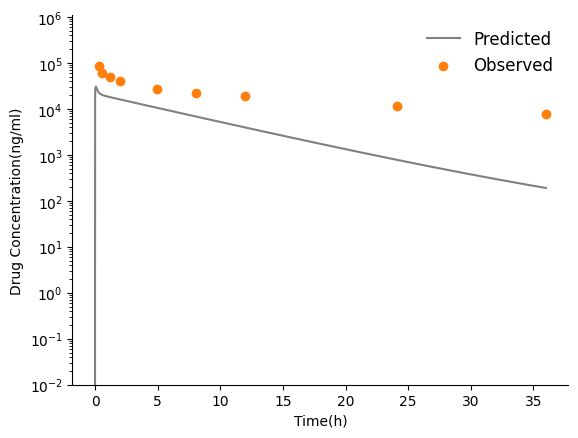

0.564674851461817
Midazolam 17.727179956160064 254.87571360171665 0.2687315700544259 6.872786957609576 5.298746195975401
Midazolam 1.7991836758098976 186.02288062935685 0.3681974521263402 0.9557203201856153 0.961678635245629


2024-01-05 05:27:05 | 347445450.py | ForkPoolWorker-106 | MainThread | 347445450.run_simulation:31 - INFO -process :30 Prazosin


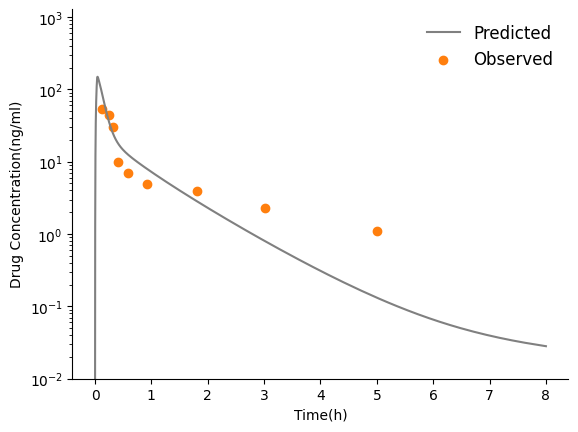

Metoprolol 3.1569371193690436 703.8056129940552 0.29195483562665214 1.3297075767148072 1.01019736506152
Nadolol 3.4242301853291903 336.1803194348811 0.16299145839368218 0.8051973483201748 0.4513208634860235
Metoprolol 1.6092980695219 133.74983493555553 1.5362968646189386 3.5668609031152063 3.2376771320702193


2024-01-05 05:27:06 | 347445450.py | ForkPoolWorker-109 | MainThread | 347445450.run_simulation:31 - INFO -process :31 Propranolol
2024-01-05 05:27:06 | fullbody_model_sm.py | ForkPoolWorker-109 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 1, 'time': 0.167, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 1, 'unit': 'mg', 'infusion_time': 0.167, 'time_range': {'start': 0}}]}
2024-01-05 05:27:06 | fullbody_model_sm.py | ForkPoolWorker-109 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 1, 'unit': 'mg', 'infusion_time': 0.167, 'time_range': {'start': 0}}


Nadolol 11.372228899668643 327.27172920574526 0.16742821227157587 2.746937458039628 2.09639802164072


2024-01-05 05:27:06 | 347445450.py | ForkPoolWorker-110 | MainThread | 347445450.run_simulation:31 - INFO -process :32 Quinidine
2024-01-05 05:27:06 | fullbody_model_sm.py | ForkPoolWorker-110 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 162, 'time': 1, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 162, 'unit': 'mg', 'infusion_time': 1, 'time_range': {'start': 0}}]}
2024-01-05 05:27:06 | fullbody_model_sm.py | ForkPoolWorker-110 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 162, 'unit': 'mg', 'infusion_time': 1, 'time_range': {'start': 0}}


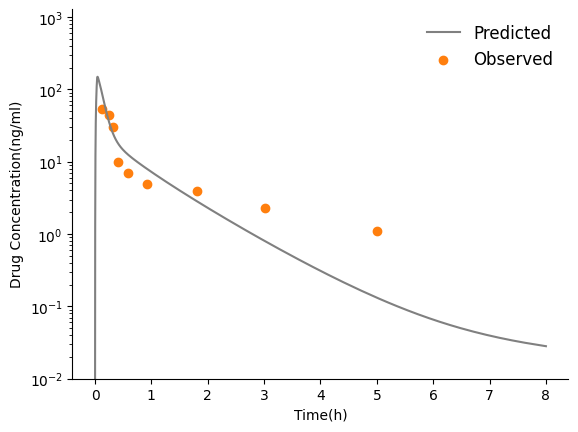

Montelukast 8.539200340466243 734.2800620937899 0.1854297078139014 2.284394236182115 1.2152269528578044
Montelukast 4.531059598710924 3224.1577086366283 0.0422303589563553 0.276057204981523 0.1681711029394394


2024-01-05 05:27:06 | 347445450.py | ForkPoolWorker-101 | MainThread | 347445450.run_simulation:31 - INFO -process :33 Ranitidine
2024-01-05 05:27:06 | fullbody_model_sm.py | ForkPoolWorker-101 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 150, 'time': 0.0333, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 150, 'unit': 'mg', 'infusion_time': 0.0333, 'time_range': {'start': 0}}]}
2024-01-05 05:27:06 | fullbody_model_sm.py | ForkPoolWorker-101 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 150, 'unit': 'mg', 'infusion_time': 0.0333, 'time_range': {'start': 0}}


Naloxone 1.5325155177193888 4.557002661078295 1.202424589652961 2.6585036976445817 1.8225389207388534
Naloxone 1.1794835011178353 4.05589683943318 1.3509840786681069 2.298881789830932 2.0457626886321596


2024-01-05 05:27:07 | 347445450.py | ForkPoolWorker-102 | MainThread | 347445450.run_simulation:31 - INFO -process :34 Rifampicin
2024-01-05 05:27:07 | fullbody_model_sm.py | ForkPoolWorker-102 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 600, 'time': 3, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 600, 'unit': 'mg', 'infusion_time': 3, 'time_range': {'start': 0}}]}
2024-01-05 05:27:07 | fullbody_model_sm.py | ForkPoolWorker-102 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 600, 'unit': 'mg', 'infusion_time': 3, 'time_range': {'start': 0}}


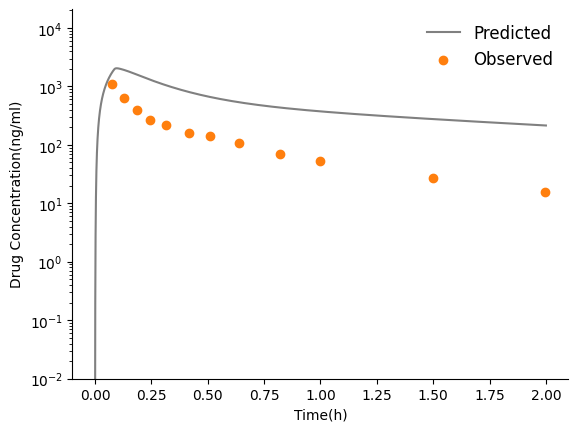

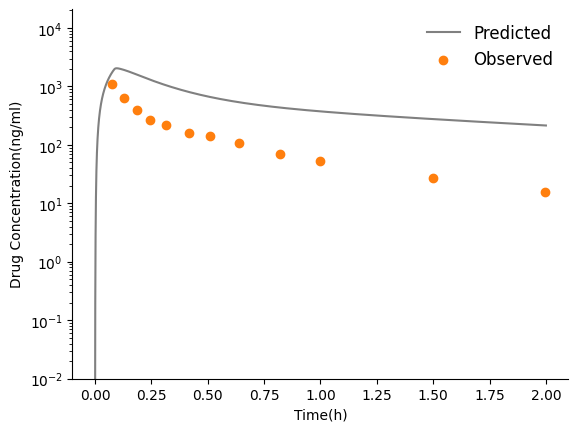

Naproxen 6.382442867091403 154670.65363232853 0.02214161157156169 0.20387815864252926 0.16341088280840146
Nifedipine 2.3615867762020417 37.112874209733285 0.4041724150824749 1.3770354371107023 0.2396581352515287
Naproxen 18.178862048006188 853158.297891376 0.0040140939175189305 0.10527585139330531 0.09734824169623603


2024-01-05 05:27:10 | 347445450.py | ForkPoolWorker-104 | MainThread | 347445450.run_simulation:31 - INFO -process :35 Sildenafil
2024-01-05 05:27:10 | fullbody_model_sm.py | ForkPoolWorker-104 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 25, 'time': 0.417, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 25, 'unit': 'mg', 'infusion_time': 0.417, 'time_range': {'start': 0}}]}
2024-01-05 05:27:10 | fullbody_model_sm.py | ForkPoolWorker-104 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 25, 'unit': 'mg', 'infusion_time': 0.417, 'time_range': {'start': 0}}


Nifedipine 1.7460063362955254 30.950765012622345 0.4846406863895835 1.2207879264245884 0.8117141502843322


2024-01-05 05:27:10 | 347445450.py | ForkPoolWorker-107 | MainThread | 347445450.run_simulation:31 - INFO -process :36 Theophylline
2024-01-05 05:27:10 | fullbody_model_sm.py | ForkPoolWorker-107 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 7.4, 'time': 0.5, 'unit': 'mg/kg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 7.4, 'unit': 'mg/kg', 'infusion_time': 0.5, 'time_range': {'start': 0}}]}
2024-01-05 05:27:10 | fullbody_model_sm.py | ForkPoolWorker-107 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 7.4, 'unit': 'mg/kg', 'infusion_time': 0.5, 'time_range': {'start': 0}}


1.460013854964929
Omeprazole 1.4280353108557395 1554.3874763537297 0.08682054415948144 0.17886937470811395 0.14051906520690954
Omeprazole 0.5549877620931483 272.99491142163845 0.4943416924108174 0.39580856313775636 0.2559144279625017


2024-01-05 05:27:11 | 347445450.py | ForkPoolWorker-108 | MainThread | 347445450.run_simulation:31 - INFO -process :37 Triazolam
2024-01-05 05:27:11 | fullbody_model_sm.py | ForkPoolWorker-108 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 1, 'time': 0.016666667, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 1, 'unit': 'mg', 'infusion_time': 0.016666667, 'time_range': {'start': 0}}]}
2024-01-05 05:27:11 | fullbody_model_sm.py | ForkPoolWorker-108 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 1, 'unit': 'mg', 'infusion_time': 0.016666667, 'time_range': {'start': 0}}


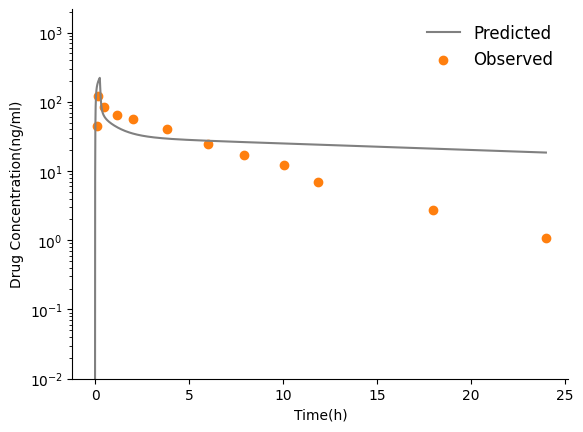

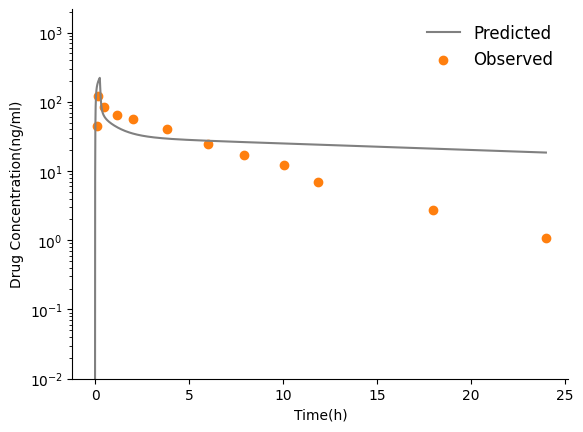

0.7181411937890038
0.5957498840878275
Ondansetron 31.6763264269229 1498.3360220254376 0.1001110550604205 4.575003041166206 4.3603767706002845
Ondansetron 4.518056485814676 437.91436933836764 0.34253271987085226 2.232689131572406 1.78022653171391


2024-01-05 05:27:19 | 347445450.py | ForkPoolWorker-103 | MainThread | 347445450.run_simulation:31 - INFO -process :38 Verapamil
2024-01-05 05:27:19 | fullbody_model_sm.py | ForkPoolWorker-103 | MainThread | fullbody_model_sm.fullbodyBuild:279 - INFO -{'iv_infusion': {}, 'dose': 10, 'time': 0.083333, 'unit': 'mg', 'dose_type': 'single', 'dosage_regimen': [{'dose': 10, 'unit': 'mg', 'infusion_time': 0.083333, 'time_range': {'start': 0}}]}
2024-01-05 05:27:19 | fullbody_model_sm.py | ForkPoolWorker-103 | MainThread | fullbody_model_sm.fullbodyBuild:281 - INFO -{'dose': 10, 'unit': 'mg', 'infusion_time': 0.083333, 'time_range': {'start': 0}}


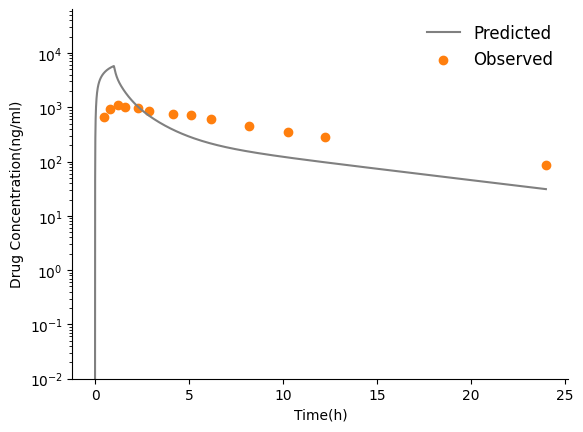

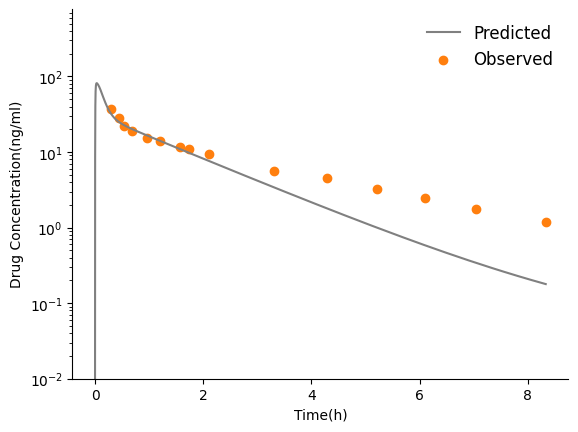

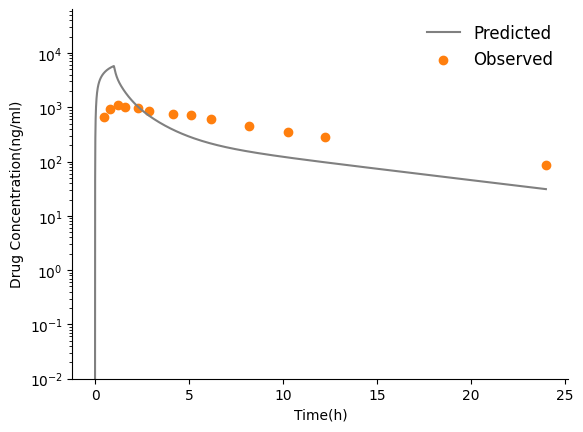

0.9475817588215198
0.8235729850889568


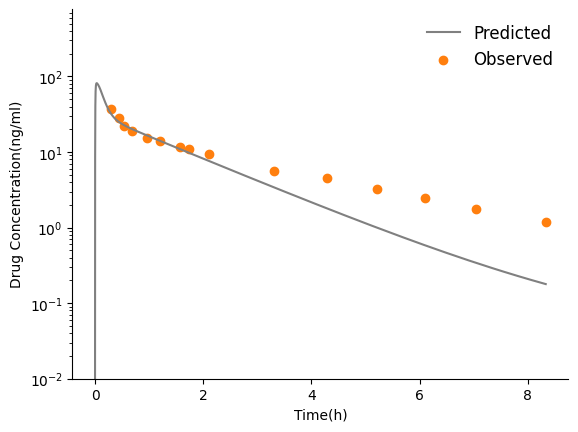

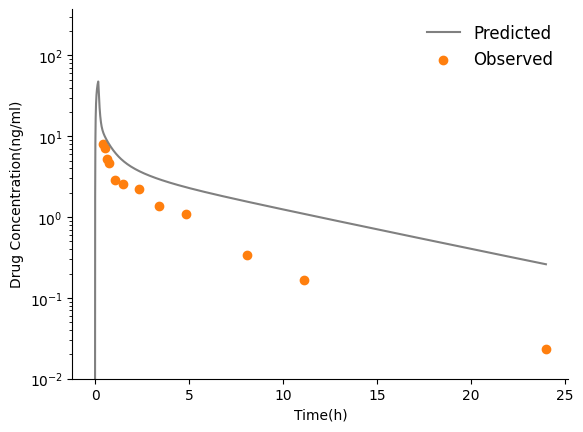

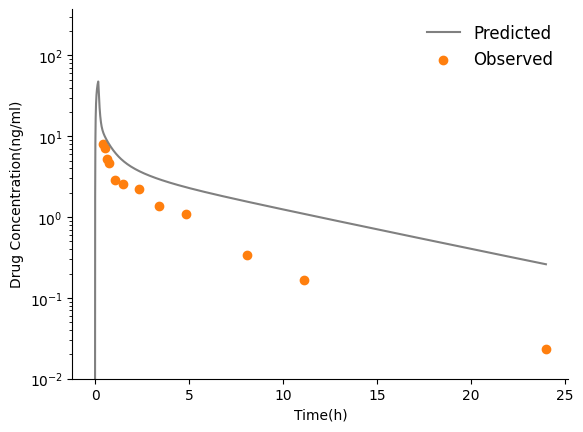

0.72478991626181340.6410993508453809

0.5729245365234193


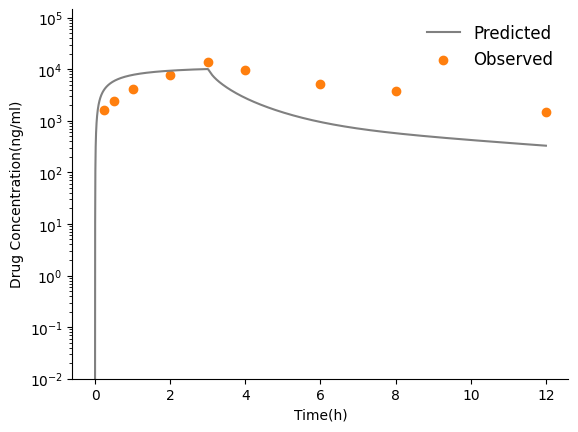

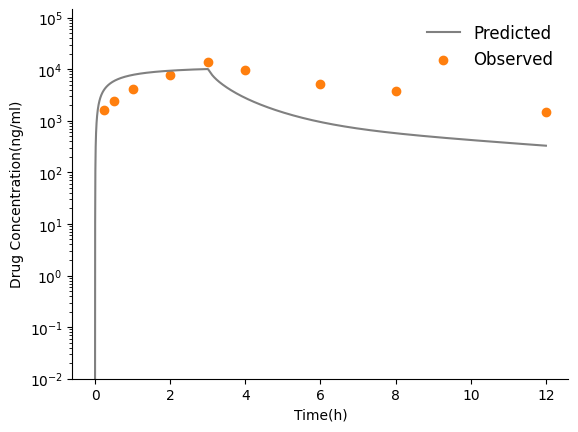

4.556222250183498
Prazosin 1.4752154121139205 55.57656558306692 0.2464821277326284 0.5245844516716734 0.33054789229694753
Prazosin 2.160623673125437 56.61774985532089 0.24194939170121255 0.7541855439498956 0.7315960917782331


2024-01-05 05:27:23 | 347445450.py | ForkPoolWorker-106 | MainThread | 347445450.run_simulation:31 - INFO -process :39 Vinorelbine


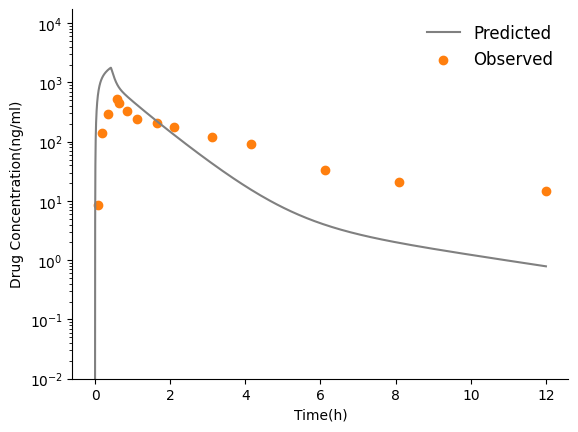

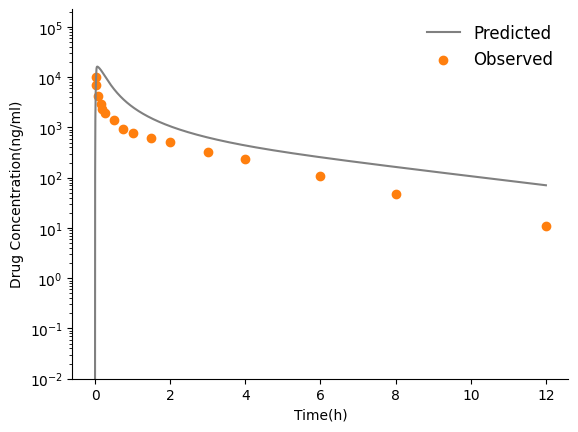

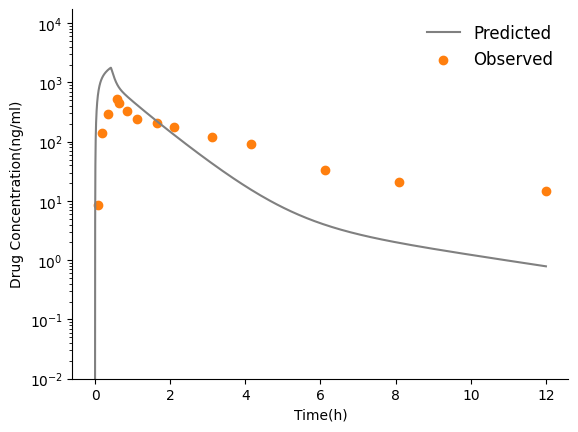

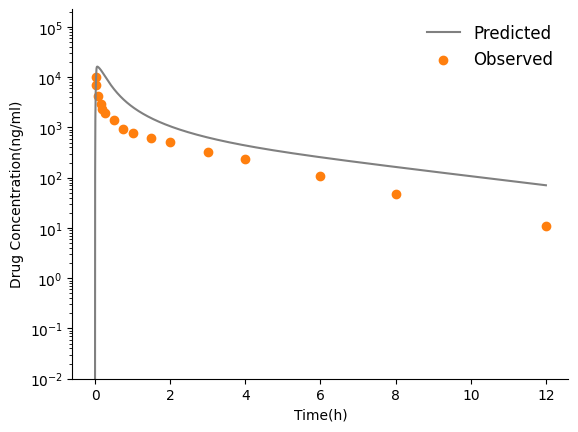

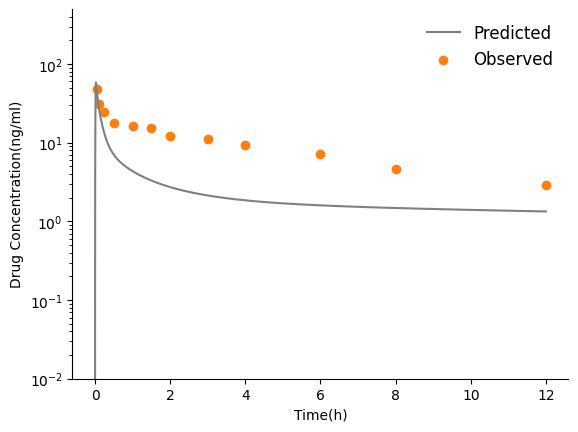

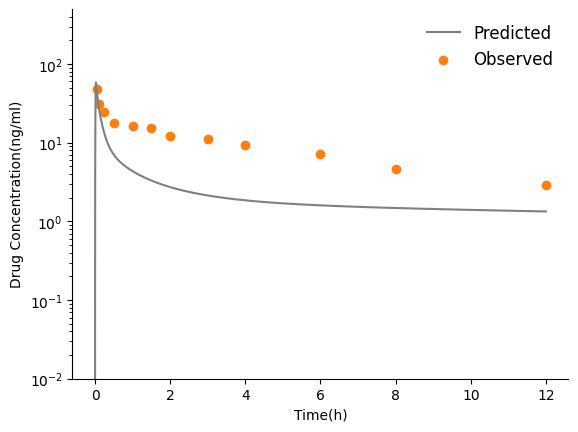

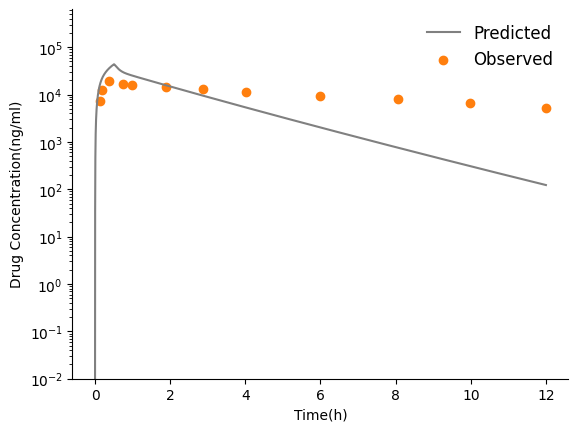

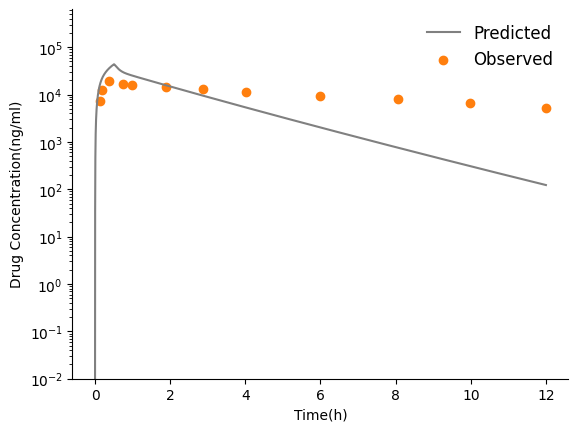

Quinidine 7.264583323704626 10406.946193171629 0.213240084170692 2.234879406362686 0.8876136349093975
Quinidine 6.908833387346579 10388.947712232015 0.2136095150020734 2.1291185919692333 2.042719908927864
Propranolol 6.318538780951134 48.82973792883016 0.2805386782323549 2.557313320579261 1.8191670248771001
Propranolol 4.2290833370217955 14.49950071709738 0.9447656442978954 5.764277422961181 3.8973704473552724
5.49550079081141
Triazolam 32.15610600406894 93.51498656547169 0.14648593386040448 6.795695559945842 5.853932101882616
Triazolam 4.296051009298928 118.42893307440741 0.1156696238104216 0.7169077766637669 0.7057721153739156
Sildenafil 3.1470848595832686 1395.4546875458384 0.24541517290464374 1.1142545142235056 0.24316726811467312
Sildenafil 2.358436327246154 1081.023192580601 0.3167977854454065 1.0779058568513706 1.0743277408054237
Rifampicin 5.635104364440289 37658.45120780627 0.2182558713537326 1.7743628593231682 0.8896039921096555
Rifampicin 3.033474858813595 70513.26128076439 

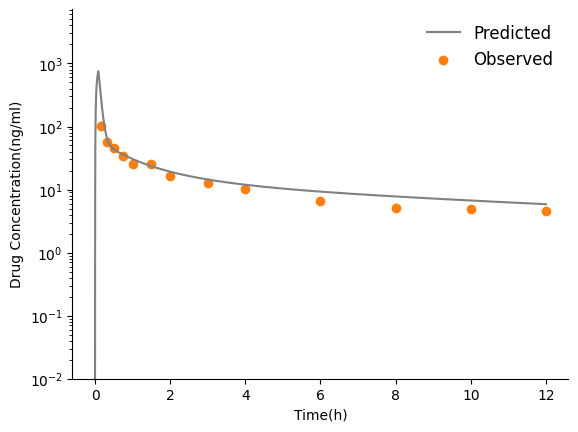

Ranitidine 3.3516376055138513 11919.585705675208 0.17238808221074384 0.8335637730116602 0.35846858663857945
Ranitidine 1.8156012669043093 3776.5863936469773 0.5440877836144692 1.4251612023287403 1.078444040943927


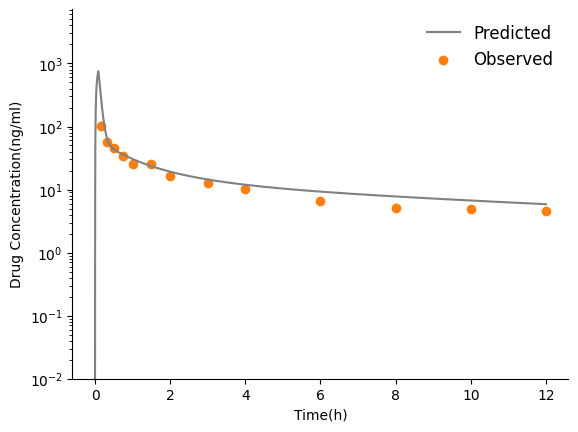

32.809252470269456


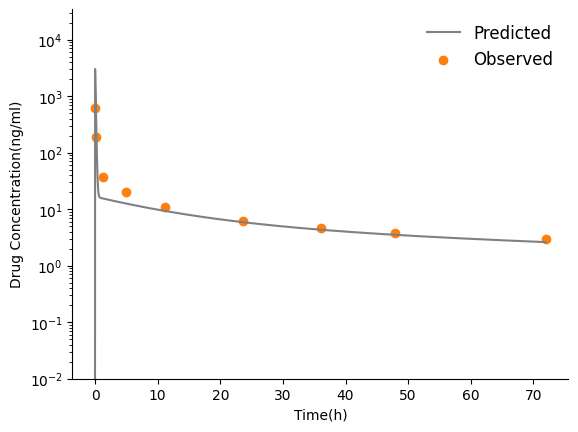

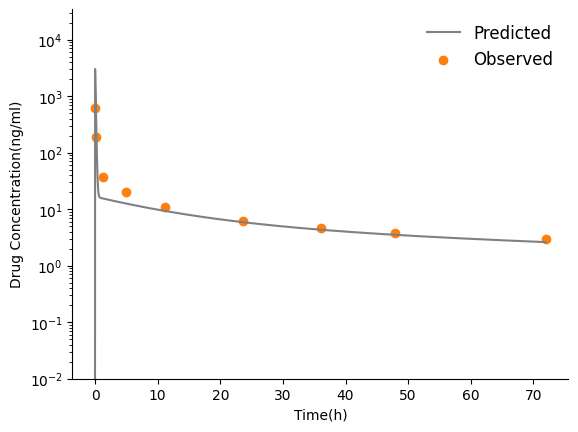

Verapamil 10.685195406340535 329.7692377249958 0.4154004852450789 6.4035972174721705 3.9246679912221607
Verapamil 5.330295900674326 179.6388249168 0.7625651160505444 5.864119231932635 4.97975267369948
Vinorelbine 66.47728348047848 941.8614827143447 0.654489399426202 62.769753034955876 36.4787060075919
Vinorelbine 58.1499496075491 939.8548699023677 0.655886750077083 55.02407358049275 35.39404264888582
Theophylline 1.537965813323056 77412.88939662704 0.09559131635154319 0.21209950891015467 0.2030857492120552
Theophylline 7.232227895899336 174558.94012502403 0.04239255803627079  0.44231968246740090.44235016066251476
Betaxolol 10.274605535106543 525.723474227457 0.25844302542710246 3.8309326129233843 3.302882070780364
Betaxolol 15.971115251072137 614.9838752634947 0.22093191493708175 5.090591399722271 4.872017399412379


2024-01-05 05:27:54 | 347445450.py | MainProcess | MainThread | 347445450.list_to_dataframe:22 - INFO -[['Acetaminophen', 1.0789461081537015, 68620.35330943989, 0.19962925686513222, 0.31074094479364706, 0.24086540358249706, 2.3952074799448986, 48090.678008603034, 0.2848500105266914, 0.9843145799493147, 0.9736874935401834], ['Alprazolam', 31.009679761331952, 26.317197160540623, 0.13013002537296886, 5.821693469040639, 5.275368704553242, 17.988136584471395, 72.91124321903463, 0.04697022548303654, 1.21894289566285, 1.0731651846277972], ['Amitriptyline', 14.98631348451714, 230.29982472319892, 0.892225829098062, 19.290529268322395, 10.866818139558367, 15.008525202920755, 677.9328635909587, 0.3030970514784982, 6.562877068000417, 6.267122136327053], ['Atenolol', 3.7167691087282857, 3745.377454546656, 0.18015910034366445, 0.9660427072251531, 0.42444129630217153, 5.7712328006194955, 4730.65152219039, 0.14263655428716504, 1.187610342733319, 0.9693677004104855], ['Betaxolol', 10.274605535106543, 5

In [17]:
%reload_ext autoreload
%autoreload 2
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
from analyze import *
import fullbody_model_sm
import multiprocessing as mp
import datetime,os,sys,json

# 定义一个多进程函数，用于并发调用get_data函数
def multi_process_get_data(param_list):
    pool = mp.Pool(processes=10) # 创建进程池，4个进程
    result_list = pool.map(run_simulation, param_list) # 并发调用
    pool.close() # 关闭进程池
    pool.join() # 等待所有子进程结束
    return result_list

# 将返回的list转换为dataframe
def list_to_dataframe(result_list):
    df_list = []
    logger.info(result_list)
    df = pd.DataFrame(result_list, columns=['Drug','T1/2_pred(h)','AUC_INF_pred(ng*h/ml)','CL_pred(L/h/kg)','Vd_pred(L/kg)','Vss_pred(L/kg)',\
                     'T1/2_obs(h)','AUC_INF_obs(ng*h/ml)','CL_obs(L/h/kg)','Vd_obs(L/kg)','Vss_obs(L/kg)'] )
    return df

def run_simulation(drug ):
# drug = 'Acetaminophen'
    # user_input = Drug_dict[drug]
    drug_index = list(Drug_dict).index(drug)
    logger.info(f"process :{drug_index} {drug}")
    try:
        file_path="./dataset"
        test_file_path = file_path
        user_input = Drug_dict[drug]
        # update 2024
        
        user_input['administration']['dose_type']="single"
        user_input['administration']['dosage_regimen']=[{'dose': 0, 'unit': 'mg/kg', 'infusion_time': 0}]
        user_input['administration']['dosage_regimen'][0]['time_range']={'start':0}
        user_input['administration']['dosage_regimen'][0]['dose']=user_input['administration']['dose']
        user_input['administration']['dosage_regimen'][0]['unit']=user_input['administration']['unit']
        if 'iv_infusion' in user_input['administration']:
            user_input['administration']['dosage_regimen'][0]['infusion_time']=user_input['administration']['time']
        
        
        simulation = fullbody_model_sm.fullbodyBuild(user_input,test_file_path,file_path , 0,Simulation_IV_Time[drug])
 
        Observation = pd.read_csv(Observation_IV_path[drug])
        y = (np.array(simulation["BDF"].y[47])*0.287+np.array(simulation["BDF"].y[51])*0.713)*user_input['molecule']['mw']
        # y = (simulation["BDF"].y[47]*0.287+simulation["BDF"].y[51]*0.713)*user_input['molecule']['mw']
        #y=simulation["BDF"].y[1]*user_input["molecule"]['mw']
        fig, ax = plt.subplots()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.semilogy()
        ax.plot(simulation["BDF"].t, y, label="Predicted", c='#808080')

        # 绘制观察数据点，使用天蓝色
        ax.scatter(Observation["Time"], Observation["Conc"], label='Observed', c='#ff7f0e')
        ax.legend(fontsize=12,frameon = False)
        ax.set_xlabel('Time(h)')
        ax.set_ylim(bottom=0.01) 
        ax.set_ylabel('Drug Concentration(ng/ml)')
        
        plt.savefig(f'{result_dir}/{drug_index}_result_{drug}.jpg')
        plt.show()
        
        fig, ax = plt.subplots()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.semilogy()
        ax.plot(simulation["BDF"].t, y, label="Predicted", c='#808080')

        # 绘制观察数据点，使用天蓝色
        ax.scatter(Observation["Time"], Observation["Conc"], label='Observed', c='#ff7f0e')
        ax.legend(fontsize=12, frameon=False)
        ax.set_xlabel('Time(h)')
        ax.set_ylim(bottom=0.01)
        ax.set_ylabel('Drug Concentration(ng/ml)')

        # 保存图片
        plt.savefig(f'{result_dir}/vpc_{drug_index}_{drug}.jpg')
        plt.show()  # 显示图表
        
        #NCA analysis of simulation results
        res = {}
        if user_input['administration']['unit'] == 'mg/kg':
            dose = user_input['administration']['dose']*1000000*user_input['individual']['weight']
        else:
            dose = user_input['administration']['dose']*1000000
        c1 = y
        t1 = simulation["BDF"].t
        thalf = t_half(c1, t1)
        AUC_INF= AUC(c1, t1)[1]
        AUMC_INF = AUMC(c1,t1)[1]
        CLinf = CL(c1, t1,dose)[1]/user_input['individual']['weight']/1000
        Vinf = volume_dist(c1, t1,dose)[1]/user_input['individual']['weight']/1000
        Vss = dose * AUMC_INF/(AUC_INF**2)/user_input['individual']['weight']/1000
        print(drug,thalf[0],AUC_INF[0],CLinf[0],Vinf[0],Vss[0])

        #import observation result
        res_obs= {}
        t = Observation['Time']
        t2 = t.values.tolist()
        c = Observation['Conc']
        c2 = c.values.tolist()
        t_obs = t_half(c2, t2)
        AUC_INF_obs= AUC(c2, t2)[1]
        AUMC_INF_obs = AUMC(c2,t2)[1]
        CLinf_obs = CL(c2, t2,dose)[1]/user_input['individual']['weight']/1000
        Vinf_obs = volume_dist(c2, t2,dose)[1]/user_input['individual']['weight']/1000
        Vss_obs = dose * AUMC_INF_obs/(AUC_INF_obs**2)/user_input['individual']['weight']/1000
        print(drug,t_obs[0],AUC_INF_obs[0],CLinf_obs[0],Vinf_obs[0],Vss_obs[0])
#         name.append(drug)
#         thalf_pred.append(thalf)
#         aucinf_prd.append(list(AUC_INF))
#         cl_prd.append(CLinf)
#         vd_prd.append(Vinf)
#         vss_prd.append(Vss)

#         thalf_obs.append(t_obs)
#         aucinf_obs.append(list(AUC_INF_obs))
#         cl_obs.append(CLinf_obs)
#         vd_obs.append(Vinf_obs)
#         vss_obs.append(Vss_obs)
        nac_result = [drug,thalf[0],AUC_INF[0],CLinf[0],Vinf[0],Vss[0],t_obs[0],AUC_INF_obs[0],CLinf_obs[0],Vinf_obs[0],Vss_obs[0]]
        
        # simu_result = [name,thalf_pred,aucinf_prd,cl_prd,vd_prd,vss_prd,thalf_obs,aucinf_obs,cl_obs,vd_obs,vss_obs]
        # logger.info(simu_result)
        return  nac_result
    except Exception as e:
        logger.error("--drug_index:%s---drug:%s error:%s---"%(drug_index,drug,e))
        return [drug]+["" for i in range(10)]
k=0
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
result_dir=f"/config/home/pbpk/ML_PBPK_test/result/result_{now_time.strftime('%Y_%m_%d_%H_%M')}"
os.makedirs(result_dir, exist_ok=True)
drug_list=[]
stopwatch = StopWatch()
stopwatch.reset()
for drug, value in Simulation_IV_Time.items():
    k+=1
    # logger.info(f"---process {k} drug {drug} simulation----")
    # result_data=run_simulation(drug)
    drug_list.append(drug)
# param_list = [1, 2, 3, 4] # 参数列表
result_list = multi_process_get_data(drug_list[0:]) # 多进程获取数据
df = list_to_dataframe(result_list) # 将返回的list转换为dataframe
logger.info(df.head())
import datetime
import os

# 目录路径



# 创建目录，如果目录存在，不会引发异常

result_file=f"{result_dir}/result%s.csv"%data_str
df.to_csv(result_file)
stopwatch.stop('cal %s nca result: '%df.shape[0])
logger.info("finish!save result at :%s"%result_file)



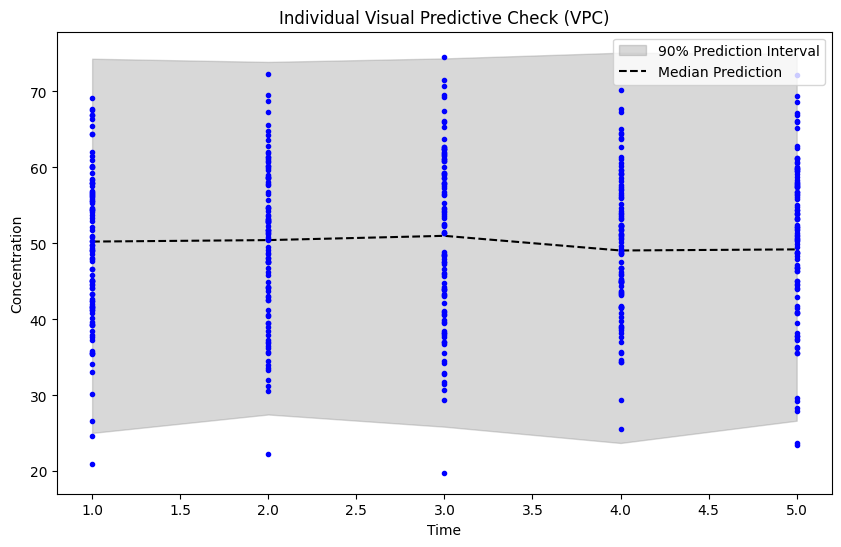

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 假设你有一个模型可以为每个个体生成药物浓度预测值
# 这里我们使用随机数来模拟这些数据
# 注意：你需要替换这一部分以使用你的实际模型数据

# 模拟的观测数据
observed_times = np.array([1, 2, 3, 4, 5])  # 观测的时间点
observed_conc = np.random.normal(50, 10, (5, 100))  # 假设有100个个体的观测数据

# 模拟的预测数据（通常来自于模型的蒙特卡洛模拟）
predicted_conc = np.random.normal(50, 15, (5, 1000))  # 1000次模拟的预测数据

# 计算预测的置信区间
lower_percentile = np.percentile(predicted_conc, 5, axis=1)  # 5th percentile
median_percentile = np.percentile(predicted_conc, 50, axis=1)  # median
upper_percentile = np.percentile(predicted_conc, 95, axis=1)  # 95th percentile

# 绘制VPC图
plt.figure(figsize=(10, 6))

# 绘制预测的置信区间
plt.fill_between(observed_times, lower_percentile, upper_percentile, color='grey', alpha=0.3, label='90% Prediction Interval')
plt.plot(observed_times, median_percentile, 'k--', label='Median Prediction')

# 绘制观测数据
# 由于我们是画个体数据，我们可以画出每个个体的观测数据点
for i in range(observed_conc.shape[1]):
    plt.plot(observed_times, observed_conc[:, i], 'bo', markersize=3)

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Individual Visual Predictive Check (VPC)')
plt.legend()
plt.show()


In [8]:
df

,Drug,T1/2_pred(h),AUC_INF_pred(ng*h/ml),CL_pred(L/h/kg),Vd_pred(L/kg),Vss_pred(L/kg),T1/2_obs(h),AUC_INF_obs(ng*h/ml),CL_obs(L/h/kg),Vd_obs(L/kg),Vss_obs(L/kg)
0,Acetaminophen,1.518896,56864.738653,0.240898,0.527882,0.51829,2.395207,48090.678009,0.28485,0.984315,0.973687
1,Amikacin,5.272622,66067.188199,0.111295,0.846597,0.6348,1.910892,82235.848467,0.089413,0.246496,0.243053
2,Alfentanil,5.808409,144.056868,0.004755,0.039842,0.02959,1.907536,301.968889,0.002268,0.006242,0.004896
3,Alprazolam,27.227682,29.094112,0.11771,4.623781,3.994507,17.988137,72.911243,0.04697,1.218943,1.073165
4,Amitriptyline,4.905212,263.097224,0.781002,5.526936,3.22495,15.008525,677.932864,0.303097,6.562877,6.267122
5,Atenolol,7.050165,2076.195222,0.325,3.305654,1.730602,5.771233,4730.651522,0.142637,1.18761,0.969368
6,Betaxolol,6.705803,299.898185,0.453052,4.383022,3.796217,15.971115,614.983875,0.220932,5.090591,4.872017
7,Caffeine,2.867161,43287.612324,0.001582,0.006545,0.006685,5.433136,62050.583324,0.001104,0.008652,0.008765
8,Chlorpromazine,19.685423,232.293457,0.589712,16.747865,4.276116,10.545329,145.140327,0.94382,14.358985,7.774391
9,Cimetidine,1.75363,7688.915553,0.485591,1.228521,0.688925,2.081596,8090.310448,0.461498,1.38593,1.284704


In [15]:
df.columns

Index(['Drug', 'T1/2_pred(h)', 'AUC_INF_pred(ng*h/ml)', 'CL_pred(L/h/kg)', 'Vd_pred(L/kg)', 'Vss_pred(L/kg)', 'T1/2_obs(h)', 'AUC_INF_obs(ng*h/ml)', 'CL_obs(L/h/kg)', 'Vd_obs(L/kg)',
       'Vss_obs(L/kg)'],
      dtype='object')

-----CL(L/h/kg)--------


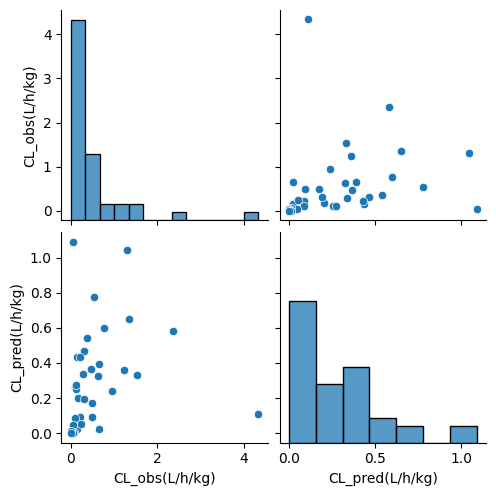

r2:-0.05182  mse:0.66746 rmse:0.81698 mae:0.38307
-----T1/2(h)--------


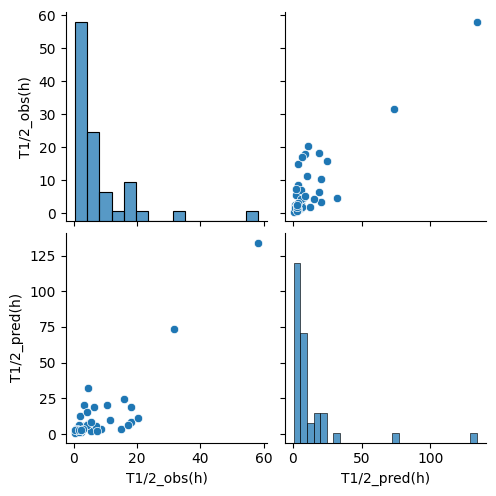

r2:-1.19757  mse:242.62908 rmse:15.57656 mae:7.74258
-----Vd(L/kg)--------


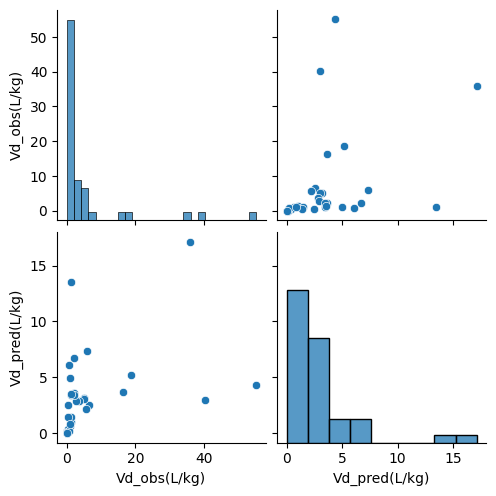

r2:0.10986  mse:123.10915 rmse:11.09546 mae:4.64289
-----Vss(L/kg)--------


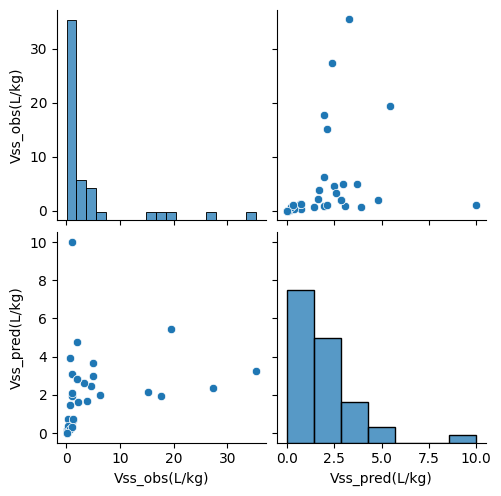

r2:0.00148  mse:60.30448 rmse:7.76560 mae:3.45578


In [36]:
# %load_ext autoreload
# %autoreload 2
import sys
sys.path.append("/data/project/pbpk/chemprop")
import pandas as pd
pd.set_option('max_colwidth',200)
pd.set_option('display.width',200)
pd.set_option('display.max_columns',200)
import os
# Datasets
from tdc.single_pred import ADME
import pandas as pd
import numpy as np

# 两种接口
import plotly_express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt 
import chemprop
#Save and load models
import joblib
import pickle
#Metrics 
import sklearn.metrics as metrics
from sklearn.feature_selection import mutual_info_regression

# RDkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
 
import seaborn as sns

import sys
import missingno
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import chembl_structure_pipeline
from loguru import logger
import datetime
import time
from pathlib import Path
import shutil
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.decomposition import PCA
def checkNan(df):
    df_data=df
    logger.info("---检测df中空值情况---")
    logger.info("数据记录数%s"%df_data.shape[0])
    null_count = df_data.isnull().sum()
    null_cols = null_count.loc[null_count > 0].index.tolist()
    logger.info(null_count.loc[null_count > 0])
    logger.info("统计每列空值数量和占比")
    null_counts = df_data.isnull().sum()
    # 计算每列空值占比
    null_ratios = null_counts / len(df_data)
    # logger.info(null_counts)
# 按占比降序排列显示
    null_ratios_sorted = null_ratios.sort_values(ascending=False)
    # logger.info(null_ratios_sorted)
    null_ratios_gt_05 = null_ratios_sorted[null_ratios_sorted > 0.5]
    logger.info("统计每列空值占比大于0.5的列名")
    logger.info(null_ratios_gt_05)
    logger.info("空值占比大于0.5的列数：%s"%len(null_ratios_gt_05))
    # logger.info('有空值的列名和数量：')
    # logger.info(null_cols[0:50])
    # logger.info(len(null_cols))
    # logger.info("空值所在行:")
    # logger.info(df_data[df_data.isnull().T.any()].index)
    logger.info("空值行数量:")
    logger.info(len(df_data[df_data.isnull().T.any()].index))
def evaluate_result(df_result,target_cols):
    # logger.info(df_result.columns)
    # logger.info(df_result)
    # logger.info("tartget空值记录数:%s"%df_result[df_result[target_cols[0]].isnull()].shape[0])

    df_result=df_result[~df_result[target_cols[0]].isnull()]
    sns.pairplot(df_result[target_cols])

    df_result = df_result.rename(columns={target_cols[0]: 'label',target_cols[1]: 'pred'})
    # print(df_result.columns)
    plt.show()
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    
    # 计算R2值
    r2 = r2_score(df_result['label'], df_result['pred'])
    # 计算MSE值
    mse = mean_squared_error(df_result['label'], df_result['pred'])
    # 计算RMSE值
    rmse = np.sqrt(mse)
    # 计算MAE值
    mae = mean_absolute_error(df_result['label'], df_result['pred'])
    metric_result="r2:%.5f  mse:%.5f rmse:%.5f mae:%.5f"%(r2,mse,rmse,mae)
    metric_list=["%.5f"%r2,"%.5f"%mse,"%.5f"%rmse,"%.5f"%mae]
    print(metric_result)
    # return df_result,metric_list
cols=['Drug', 'T1/2_pred(h)', 'AUC_INF_pred(ng*h/ml)', 'CL_pred(L/h/kg)',
       'Vd_pred(L/kg)', 'Vss_pred(L/kg)', 'T1/2_obs(h)',
       'AUC_INF_obs(ng*h/ml)', 'CL_obs(L/h/kg)', 'Vd_obs(L/kg)',
       'Vss_obs(L/kg)']
# checkNan(df)
df_data=df[df['CL_pred(L/h/kg)']!=""]
print("-----CL(L/h/kg)--------")

target_cols=['CL_obs(L/h/kg)','CL_pred(L/h/kg)']
df_data[target_cols] =  df_data[target_cols].astype('float')
df_result=df_data[[ 'Drug']+target_cols]
# print(df_result.head(2))
evaluate_result(df_result,target_cols)
print("-----T1/2(h)--------")

target_cols=['T1/2_obs(h)','T1/2_pred(h)']
df_data[target_cols] =  df_data[target_cols].astype('float')
df_result=df_data[[ 'Drug']+target_cols]
# print(df_result.head(2))
evaluate_result(df_result,target_cols)
print("-----Vd(L/kg)--------")

target_cols=['Vd_obs(L/kg)','Vd_pred(L/kg)']
df_data[target_cols] =  df_data[target_cols].astype('float')
df_result=df_data[[ 'Drug']+target_cols]
# print(df_result.head(2))
evaluate_result(df_result,target_cols)
print("-----Vss(L/kg)--------")
target_cols=['Vss_obs(L/kg)','Vss_pred(L/kg)']
df_data[target_cols] =  df_data[target_cols].astype('float')
df_result=df_data[[ 'Drug']+target_cols]
# print(df_result.head(2))
evaluate_result(df_result,target_cols)


In [9]:
df.columns

Index(['Drug', 'T1/2_pred(h)', 'AUC_INF_pred(ng*h/ml)', 'CL_pred(L/h/kg)', 'Vd_pred(L/kg)', 'Vss_pred(L/kg)', 'T1/2_obs(h)', 'AUC_INF_obs(ng*h/ml)', 'CL_obs(L/h/kg)', 'Vd_obs(L/kg)',
       'Vss_obs(L/kg)'],
      dtype='object')

In [19]:
df

,Drug,T1/2_pred(h),AUC_INF_pred(ng*h/ml),CL_pred(L/h/kg),Vd_pred(L/kg),Vss_pred(L/kg),T1/2_obs(h),AUC_INF_obs(ng*h/ml),CL_obs(L/h/kg),Vd_obs(L/kg),Vss_obs(L/kg)
0,Acetaminophen,0.999817,34318.354369,0.399163,0.575765,0.553769,2.395207,48090.678009,0.284850,0.984315,0.973687
1,Alprazolam,24.373282,25.372637,0.134974,4.746135,4.017606,17.988137,72.911243,0.046970,1.218943,1.073165
2,Amitriptyline,4.879188,259.680563,0.791278,5.569947,3.235553,15.008525,677.932864,0.303097,6.562877,6.267122
3,Atenolol,6.775275,1870.061427,0.360824,3.526934,1.756406,5.771233,4730.651522,0.142637,1.187610,0.969368
4,Betaxolol,6.144067,262.886826,0.516837,4.581248,3.877414,15.971115,614.983875,0.220932,5.090591,4.872017
5,Bosentan,15.640097,18046.734460,0.188219,4.246954,0.505407,3.306813,34350.899751,0.098884,0.471746,0.253839
6,Caffeine,3.028594,46027.015956,0.001488,0.006502,0.006645,5.433136,62050.583324,0.001104,0.008652,0.008765
7,Chlorpromazine,19.281787,523.238870,0.654511,18.207024,4.331023,10.545329,145.140327,2.359549,35.897462,19.435978
8,Cimetidine,1.597815,6573.060563,0.568025,1.309389,0.669601,2.081596,8090.310448,0.461498,1.385930,1.284704
9,Clozapine,9.825083,12774.246003,0.321709,4.560095,2.860420,6.422853,947.205926,4.338644,40.202820,27.321450


In [14]:
data = df.dropna(axis = 0,subset = ['CL_pred(L/h/kg)','CL_obs(L/h/kg)'])
data=df[df['CL_pred(L/h/kg)']!=""]
print(data.shape)
data_null=df[df['CL_pred(L/h/kg)']==""]
print(data_null)

(38, 11)
           Drug T1/2_pred(h) AUC_INF_pred(ng*h/ml) CL_pred(L/h/kg) Vd_pred(L/kg) Vss_pred(L/kg) T1/2_obs(h) AUC_INF_obs(ng*h/ml) CL_obs(L/h/kg) Vd_obs(L/kg) Vss_obs(L/kg)
15  Fluconazole                                                                                                                                                           
37    Verapamil                                                                                                                                                           


In [ ]:
df_result.info()

# Predicted vs Observed Comparison Chart

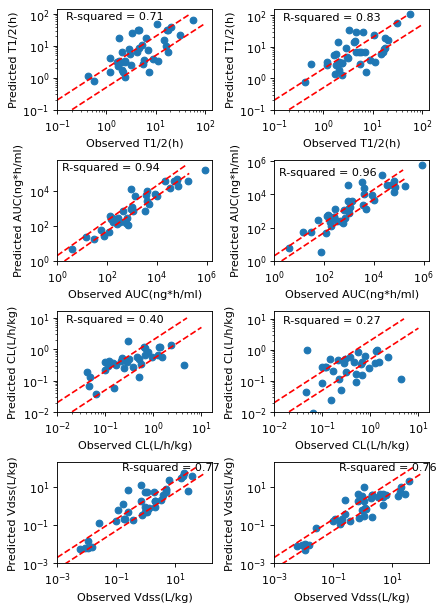

Date 06028: AUC 2-FOLD 0.625
Date 06028: AUC 3-FOLD 0.8
Date 06028 vitro: AUC 2-FOLD 0.475
Date 06028 vitro: AUC 3-FOLD 0.625
CPU times: user 3.13 s, sys: 5.79 s, total: 8.92 s
Wall time: 1.37 s


In [5]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
nca = pd.read_csv('./result/result2023_06_21_17_06.csv')
# nca = pd.read_csv('result/result2023_06_16_14_11.csv')

Y_test_T_ML = nca['T1/2_obs(h)']
Y_pred_T_ML = nca['T1/2_pred(h)']
Y_test_AUC_ML = nca['AUC_INF_obs(ng*h/ml)'] 
Y_pred_AUC_ML = nca['AUC_INF_pred(ng*h/ml)']
Y_test_CL_ML = nca['CL_obs(L/h/kg)']
Y_pred_CL_ML = nca['CL_pred(L/h/kg)']
Y_test_V_ML = nca['Vss_obs(L/kg)']
Y_pred_V_ML = nca['Vss_pred(L/kg)']

ncaV = pd.read_csv('./result/resultobs2023_06_21_17_11.csv')
Y_test_T_V = ncaV['T1/2_obs(h)']
Y_pred_T_V = ncaV['T1/2_pred(h)']
Y_test_AUC_V = ncaV['AUC_INF_obs(ng*h/ml)'] 
Y_pred_AUC_V = ncaV['AUC_INF_pred(ng*h/ml)']
Y_test_CL_V = ncaV['CL_obs(L/h/kg)']
Y_pred_CL_V = ncaV['CL_pred(L/h/kg)']
Y_test_V_V = ncaV['Vss_obs(L/kg)']
Y_pred_V_V = ncaV['Vss_pred(L/kg)']

# n = ['Acetaminophen','Alfentanil','Alprazolam','Amikacin','Amitriptyline','Atenolol','Betaxolol','Caffeine','Chlorpromazine','Cimetidine',\
#              'Ciprofloxacin','Diazepam','Digoxin','Doxycycline','Erythromycin','Fluconazole','Fluvastatin','Furosemide','Ibuprofen','Imatinib',\
#                 'Imipramine','Ketoprofen','Metformin','Methylprednisolone','Metoprolol','Midazolam','Montelukast','Morphine','Nifedipine',\
#              'Omeprazole','Ondansetron','Prazosin','Ranitidine','Sildenafil','Sufentanil','Theophylline','Triazolam','Verapamil','Vinorelbine','Zidovudine']

plt.figure(figsize =(6,9),dpi = 80)
plt.figure(1)

#p1
ax1 = plt.subplot(421)
ax1.scatter(Y_test_T_ML,Y_pred_T_ML)
# for i, txt in enumerate(n):
#     plt.annotate(txt, (Y_test[i], Y_pred[i]),fontsize=6)

ax1.set_xlabel('Observed T1/2(h)')
ax1.set_ylabel('Predicted T1/2(h)')
r_squaredtml = pearsonr(Y_test_T_ML, Y_pred_T_ML)[0]
x2 = [0.1,1,10,100]
y2 = [0.05,0.5,5,50]
x3 = [0.1,1,10,50]
y3 = [0.2,2,20,100]
# plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, Y_pred, 1))(np.unique(Y_test)))
ax1.plot(x2,y2,linestyle = 'dashed',color = 'red')
ax1.plot(x3,y3,linestyle = 'dashed', color = 'red')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.1)
ax1.set_ylim(bottom=0.1)
ax1.text(0.15, 70, 'R-squared = %0.2f' % r_squaredtml)

#p2
ax2 = plt.subplot(422)
ax2.scatter(Y_test_T_V,Y_pred_T_V)
# for i, txt in enumerate(n):
#     plt.annotate(txt, (Y_test[i], Y_pred[i]),fontsize=6)
r_squaredtv = pearsonr(Y_test_T_V, Y_pred_T_V)[0]
ax2.set_xlabel('Observed T1/2(h)')
ax2.set_ylabel('Predicted T1/2(h)')

x2 = [0.1,1,10,100]
y2 = [0.05,0.5,5,50]
x3 = [0.1,1,10,50]
y3 = [0.2,2,20,100]
# plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, Y_pred, 1))(np.unique(Y_test)))
ax2.plot(x2,y2,linestyle = 'dashed',color = 'red')
ax2.plot(x3,y3,linestyle = 'dashed', color = 'red')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.1)
ax2.set_ylim(bottom=0.1)
ax2.text(0.15, 70, 'R-squared = %0.2f' % r_squaredtv)

#p3
ax3 = plt.subplot(423)
ax3.scatter(Y_test_AUC_ML,Y_pred_AUC_ML)
# for i, txt in enumerate(n):
#     plt.annotate(txt, (Y_test[i], Y_pred[i]),fontsize=6)
r_squaredaml = pearsonr(Y_test_AUC_ML, Y_pred_AUC_ML)[0]
ax3.set_xlabel('Observed AUC(ng*h/ml)')
ax3.set_ylabel('Predicted AUC(ng*h/ml)')

x2 = [1,10,100,1000,10000,100000,150000,200000]
y2 = [0.5,5,50,500,5000,50000,75000,100000]
x3 = [1,10,100,1000,10000,100000,150000]
y3 = [2,20,200,2000,20000,200000,300000]
# plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, Y_pred, 1))(np.unique(Y_test)))
ax3.plot(x2,y2,linestyle = 'dashed',color = 'red')
ax3.plot(x3,y3,linestyle = 'dashed', color = 'red')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(1)
ax3.set_ylim(bottom=1)
ax3.text(1.5, 150000, 'R-squared = %0.2f' % r_squaredaml)

#p4
ax4 = plt.subplot(424)
ax4.scatter(Y_test_AUC_V,Y_pred_AUC_V)
# for i, txt in enumerate(n):
#     plt.annotate(txt, (Y_test[i], Y_pred[i]),fontsize=6)
r_squaredauv = pearsonr(Y_test_AUC_V, Y_pred_AUC_V)[0]
ax4.set_xlabel('Observed AUC(ng*h/ml)')
ax4.set_ylabel('Predicted AUC(ng*h/ml)')

x2 = [1,10,100,1000,10000,100000,150000,200000]
y2 = [0.5,5,50,500,5000,50000,75000,100000]
x3 = [1,10,100,1000,10000,100000,150000]
y3 = [2,20,200,2000,20000,200000,300000]
# plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, Y_pred, 1))(np.unique(Y_test)))
ax4.plot(x2,y2,linestyle = 'dashed',color = 'red')
ax4.plot(x3,y3,linestyle = 'dashed', color = 'red')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(1)
ax4.set_ylim(bottom=1)
ax4.text(1.5, 150000, 'R-squared = %0.2f' % r_squaredauv)

#p5
ax5 = plt.subplot(425)
ax5.scatter(Y_test_CL_ML,Y_pred_CL_ML)
# for i, txt in enumerate(n):
#     plt.annotate(txt, (Y_test[i], Y_pred[i]),fontsize=6)
r_squaredclm = pearsonr(Y_test_CL_ML, Y_pred_CL_ML)[0]
ax5.set_xlabel('Observed CL(L/h/kg)')
ax5.set_ylabel('Predicted CL(L/h/kg)')

x2 = [0.01,0.1,1,10]
y2 = [0.005,0.05,0.5,5]
x3 = [0.01,0.1,1,5]
y3 = [0.02,0.2,2,10]
# plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, Y_pred, 1))(np.unique(Y_test)))
ax5.plot(x2,y2,linestyle = 'dashed',color = 'red')
ax5.plot(x3,y3,linestyle = 'dashed', color = 'red')
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlim(0.01)
ax5.set_ylim(bottom=0.01)
ax5.text(0.015, 7, 'R-squared = %0.2f' % r_squaredclm)

#p6
ax6 = plt.subplot(426)
ax6.scatter(Y_test_CL_V,Y_pred_CL_V)
# for i, txt in enumerate(n):
#     plt.annotate(txt, (Y_test[i], Y_pred[i]),fontsize=6)
r_squaredclv = pearsonr(Y_test_CL_V, Y_pred_CL_V)[0]
ax6.set_xlabel('Observed CL(L/h/kg)')
ax6.set_ylabel('Predicted CL(L/h/kg)')

x2 = [0.01,0.1,1,10]
y2 = [0.005,0.05,0.5,5]
x3 = [0.01,0.1,1,5]
y3 = [0.02,0.2,2,10]
# plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, Y_pred, 1))(np.unique(Y_test)))
ax6.plot(x2,y2,linestyle = 'dashed',color = 'red')
ax6.plot(x3,y3,linestyle = 'dashed', color = 'red')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xlim(0.01)
ax6.set_ylim(bottom=0.01)
ax6.text(0.015, 7, 'R-squared = %0.2f' % r_squaredclv)

#p7
ax7= plt.subplot(427)
ax7.scatter(Y_test_V_ML,Y_pred_V_ML)
# for i, txt in enumerate(n):
#     plt.annotate(txt, (Y_test[i], Y_pred[i]),fontsize=6)
r_squaredvml = pearsonr(Y_test_V_ML, Y_pred_V_ML)[0]
ax7.set_xlabel('Observed Vdss(L/kg)')
ax7.set_ylabel('Predicted Vdss(L/kg)')

x2 = [0.001,0.1,1,10,100]
y2 = [0.0005,0.05,0.5,5,50]
x3 = [0.001,0.1,1,5,50]
y3 = [0.002,0.2,2,10,100]
# plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, Y_pred, 1))(np.unique(Y_test)))
ax7.plot(x2,y2,linestyle = 'dashed',color = 'red')
ax7.plot(x3,y3,linestyle = 'dashed', color = 'red')
ax7.set_xscale('log')
ax7.set_yscale('log')
ax7.set_xlim(0.001)
ax7.set_ylim(bottom=0.001)
ax7.text(0.15, 70, 'R-squared = %0.2f' % r_squaredvml)

#p4
ax8 = plt.subplot(428)
ax8.scatter(Y_test_V_V,Y_pred_V_V)
# for i, txt in enumerate(n):
#     plt.annotate(txt, (Y_test[i], Y_pred[i]),fontsize=6)
r_squaredvv = pearsonr(Y_test_V_V, Y_pred_V_V)[0]
ax8.set_xlabel('Observed Vdss(L/kg)')
ax8.set_ylabel('Predicted Vdss(L/kg)')

x2 = [0.001,0.1,1,10,100]
y2 = [0.0005,0.05,0.5,5,50]
x3 = [0.001,0.1,1,5,50]
y3 = [0.002,0.2,2,10,100]
# plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, Y_pred, 1))(np.unique(Y_test)))
ax8.plot(x2,y2,linestyle = 'dashed',color = 'red')
ax8.plot(x3,y3,linestyle = 'dashed', color = 'red')
ax8.set_xscale('log')
ax8.set_yscale('log')
ax8.set_xlim(0.001)
ax8.set_ylim(bottom=0.001)
ax8.text(0.15, 70, 'R-squared = %0.2f' % r_squaredvv)

plt.subplots_adjust(wspace=0.4,hspace =0.5)
plt.show()

Ratio = Y_test_AUC_ML/Y_pred_AUC_ML
N_2fold = []
N_3fold = []
for i in list(Ratio):
    if i <=2 and i >=0.5:
        N_2fold.append(i)
    if i <=3 and i>=0.333:
        N_3fold.append(i)
print('Date 06028: AUC 2-FOLD',len(N_2fold)/40)
print('Date 06028: AUC 3-FOLD',len(N_3fold)/40)

Ratio_obs = Y_test_AUC_V/Y_pred_AUC_V
N_2fold_obs = []
N_3fold_obs = []
for i in list(Ratio_obs):
    if i <=2 and i >=0.5:
        N_2fold_obs.append(i)
    if i <=3 and i>=0.333:
        N_3fold_obs.append(i)
print('Date 06028 vitro: AUC 2-FOLD',len(N_2fold_obs)/40)
print('Date 06028 vitro: AUC 3-FOLD',len(N_3fold_obs)/40)

In [33]:
print(nca.shape)
print(nca)

(40, 12)
    Unnamed: 0                Drug  T1/2_pred(h)  AUC_INF_pred(ng*h/ml)  CL_pred(L/h/kg)  Vd_pred(L/kg)  Vss_pred(L/kg)  T1/2_obs(h)  AUC_INF_obs(ng*h/ml)  CL_obs(L/h/kg)  Vd_obs(L/kg)  \
0            0       Acetaminophen      1.518623           56864.386590         0.240900       0.527790        0.518267     2.395207          48090.678009        0.284850      0.984315   
1            1            Amikacin      5.272558           66066.988261         0.111295       0.846589        0.634796     1.910892          82235.848467        0.089413      0.246496   
2            2          Alfentanil      5.808409             144.056868         0.004755       0.039842        0.029590     1.907536            301.968889        0.002268      0.006242   
3            3          Alprazolam     27.227682              29.094113         0.117710       4.623781        3.994507    17.988137             72.911243        0.046970      1.218943   
4            4       Amitriptyline      4.905212   

In [62]:
df_fold

,ratio
0,0.845708
1,1.244734
2,2.096178
3,2.506048
4,2.576739
5,2.278526
6,2.050617
7,1.433438
8,0.624815
9,1.052198


In [63]:
# Ratio['A_cat']=pd.cut(Ratio,bins=np.linspace(0,1,5),labels=[1,2,3,4])
# Ratio
ratio_data = {'ratio':Ratio,}
df_fold = pd.DataFrame(ratio_data)
# df_fold.select_dtypes(include=['float','int','object'])
df_fold.info()
print(df_fold.shape)
print(df_fold.columns)
df_fold.astype({'ratio':'float'})
df_fold.info()
# df_fold[['ratio']] =  df_fold[['ratio']].astype('float')
# df_fold['fold']=pd.cut(df_fold['ratio'],bins=np.linspace(0,1,5),labels=[1,2,3,4])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ratio   40 non-null     float64
dtypes: float64(1)
memory usage: 448.0 bytes
(40, 1)
Index(['ratio'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ratio   40 non-null     float64
dtypes: float64(1)
memory usage: 448.0 bytes


In [88]:
df_fold['fold']=pd.cut(df_fold['ratio'],bins= [0, 1, 2, 3,4,5,10],labels=[1,2,3,4,5,6])

In [89]:
df_fold['fold'].value_counts()

1    18
2    12
3     6
4     2
6     2
5     0
Name: fold, dtype: int64

In [90]:
df_fold['%'] = 100 * (df_fold['fold'] / df.groupby('fold')['fold'].transform('sum'))

KeyError: 'fold'

           ratio
count  40.000000
mean    1.674718
std     1.949332
min     0.246947
25%     0.690774
50%     1.051862
75%     1.940151
max     9.211114
<class 'pandas.core.series.Series'>


<AxesSubplot: ylabel='Frequency'>

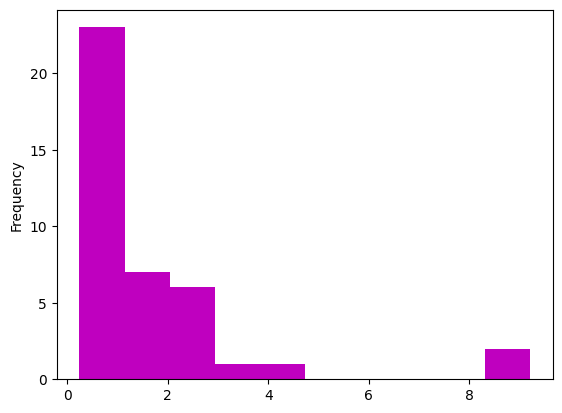

In [67]:
print(df_fold.describe())
print(type(Ratio))
Ratio.plot.hist(color="m")

In [68]:
df_fold

,ratio,fold
0,0.845708,4
1,1.244734,NaN
2,2.096178,NaN
3,2.506048,NaN
4,2.576739,NaN
5,2.278526,NaN
6,2.050617,NaN
7,1.433438,NaN
8,0.624815,3
9,1.052198,NaN
